# Phase 2 Group 1 Project

## Import

In [1]:
#import appropriate libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
pd.set_option('display.max_columns', None)
%matplotlib inline

import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (15.0, 9.0)
%config InlineBackend.figure_format ='retina'

In [2]:
cd ..

/Users/arthur/Documents/Flatiron/phase_2/Project/dsc-phase-2-project


In [3]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

In [4]:
def normality(ols_model):
    residuals = ols_model.resid
    name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
    test = sms.jarque_bera(residuals)
    for name, test in zip(name, test):
        print('\n',name, '----')
        print(test)
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    fig.show();

## Review the Data File

In [5]:
#read in the file
df = pd.read_csv('data/kc_house_data.csv')

In [6]:
#check the first 5 entries in the data
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0         NaN   0.0          3      7        1180   
1      7242     2.0         0.0   0.0          3      7        2170   
2     10000     1.0         0.0   0.0          3      6         770   
3      5000     1.0         0.0   0.0          5      7        1050   
4      8080     1.0         0.0   0.0          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0           0.0      1955           0.0    98178  47.5112 -122.257   
1         400.0      1951        1991.0    98125  47.7210 -122.319   
2           0.0      1933           NaN    98028  47.7379 -122.233   
3         910.0      1965           0.0    98136  47.5208 -122.393   
4           0.0      1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

In [7]:
#check the columns and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

## Cleaning the Data

In [8]:
#for year renovated, convert any houses that have been renovated to '1' to indicate true
#for any nulls, assume no renovation
df['yr_renovated'].fillna(0, inplace=True)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else x)

In [9]:
df.rename(columns={'yr_renovated': 'if_renovated'}, inplace=True)

In [10]:
#for any nulls, assume no waterfront
df['waterfront'].fillna(0, inplace=True)

In [11]:
#for any nulls, assume no one viewed the property
df['view'].fillna(0, inplace=True)

In [12]:
#clean up sqft_basement and convert to int
df['sqft_basement'] = df['sqft_basement'].replace({'?':np.nan}).astype(float)
df['sqft_basement'].fillna(df['sqft_living']-df['sqft_above'], inplace=True)

In [13]:
#retrieve the months and year
df['month_of_date'] = pd.DatetimeIndex(df['date']).month
df['year_of_date'] = pd.DatetimeIndex(df['date']).year

In [14]:
#convert yr_built to age of house by subtracting year the property was sold by the year it was built
#to create a more sensible column 
df['age_of_house'] = df['year_of_date'] - df['yr_built']

#drop year of date because years are only 2014 and 2015, and will not impact our predicative model
#drop yr_built b/c it is redundant with age_of_house
df.drop(columns=['year_of_date'], inplace=True)
df.drop(columns=['yr_built'], inplace=True)

In [15]:
#drop duplicates if any
df.drop_duplicates(inplace=True)

In [16]:
#drop id and date columns
df.drop(columns=['id'], inplace=True)
df.drop(columns=['date'], inplace=True)

In [17]:
#reset index
df.reset_index(inplace=True, drop=True)

In [18]:
#convert some of the categorical data from floats to ints
df['waterfront'] = df['waterfront'].astype(int)
df['view'] = df['view'].astype(int)
df['sqft_basement'] = df['sqft_basement'].astype(int)
df['if_renovated'] = df['if_renovated'].astype(int)

In [19]:
#check cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  int64  
 7   view           21597 non-null  int64  
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  int64  
 12  if_renovated   21597 non-null  int64  
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

In [20]:
df.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  221900.0         3       1.00         1180      5650     1.0           0   
1  538000.0         3       2.25         2570      7242     2.0           0   
2  180000.0         2       1.00          770     10000     1.0           0   
3  604000.0         4       3.00         1960      5000     1.0           0   
4  510000.0         3       2.00         1680      8080     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  if_renovated  zipcode  \
0     0          3      7        1180              0             0    98178   
1     0          3      7        2170            400             1    98125   
2     0          3      6         770              0             0    98028   
3     0          5      7        1050            910             0    98136   
4     0          3      8        1680              0             0    98074   

       lat     long  sqft_living15  sqft_lot15  month_of_date  age_of_house  
0  47.5112 -122.257           1340        5650             10            59  
1  47.7210 -122.319           1690        7639             12            63  
2  47.7379 -122.233           2720        8062              2            82  
3  47.5208 -122.393           1360        5000             12            49  
4  47.6168 -122.045           1800        7503              2            28

## EDA

### Target: Price

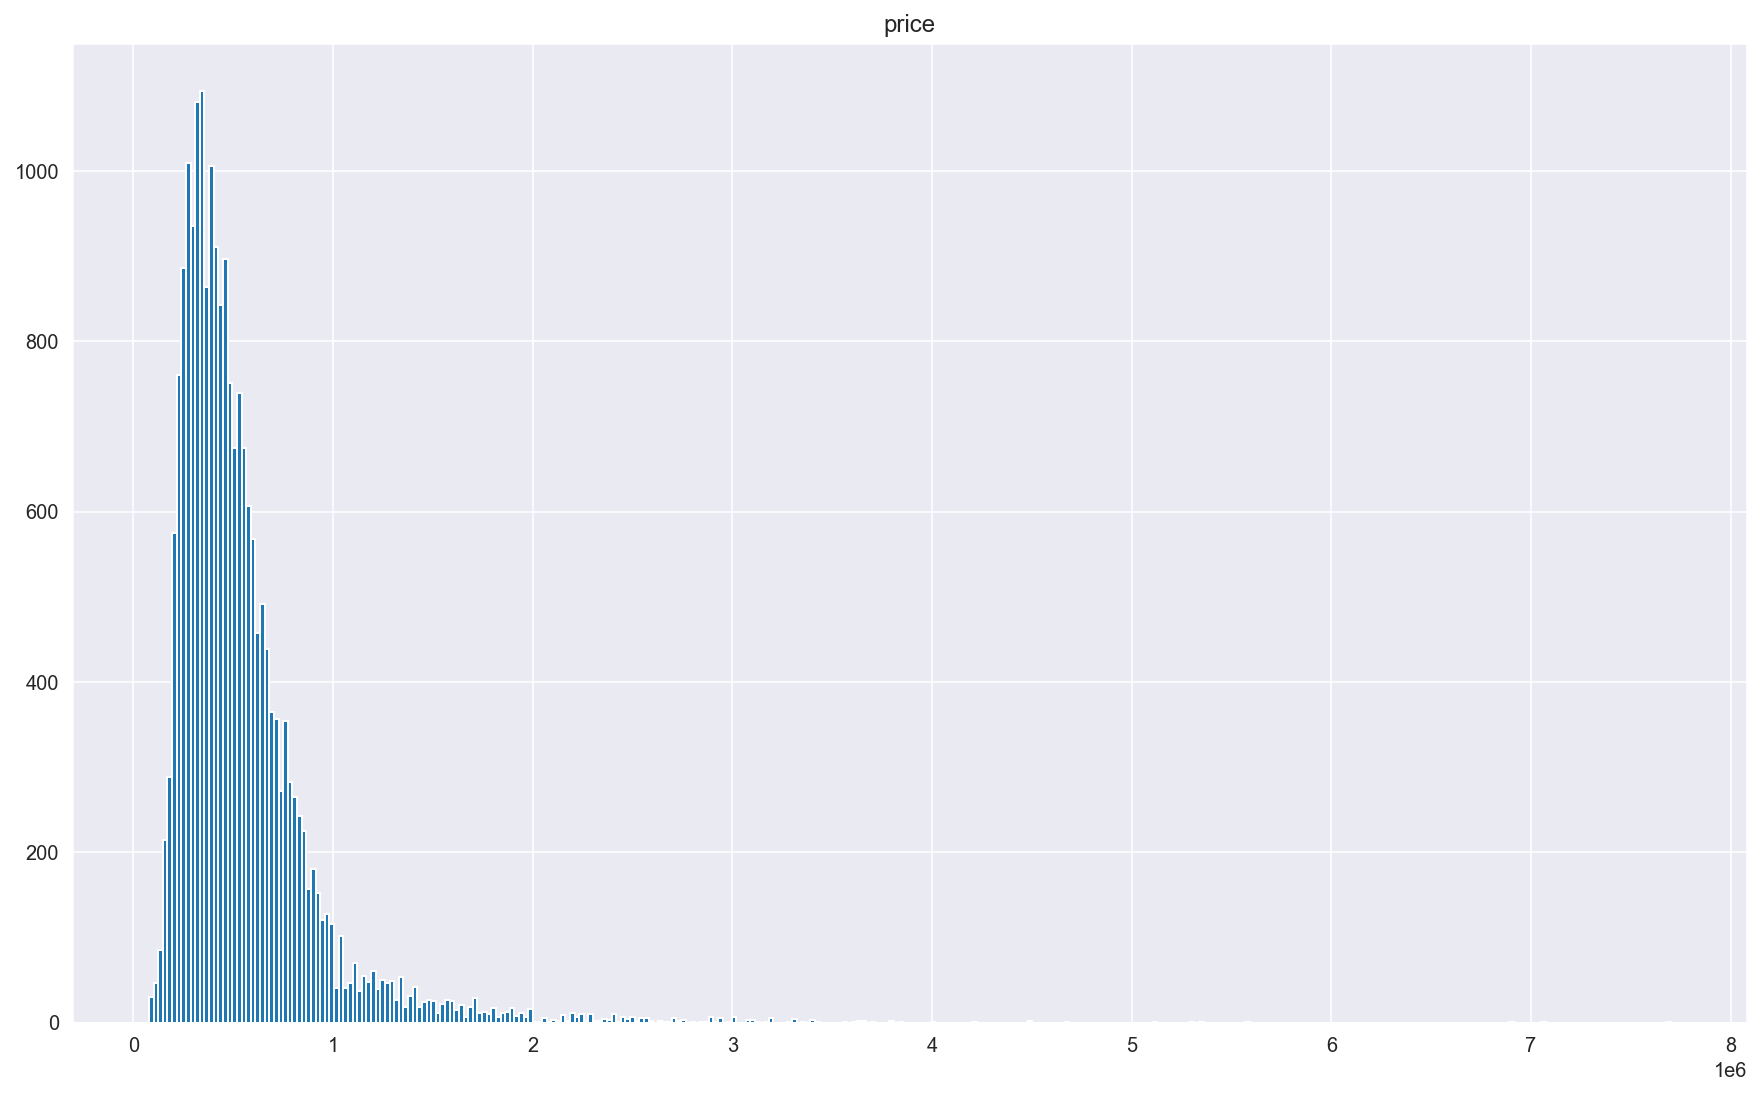

In [21]:
#Since price is our target, we will explore first
#view distribution of price using histogram
df.hist(column=['price'], bins='auto');

<AxesSubplot:>

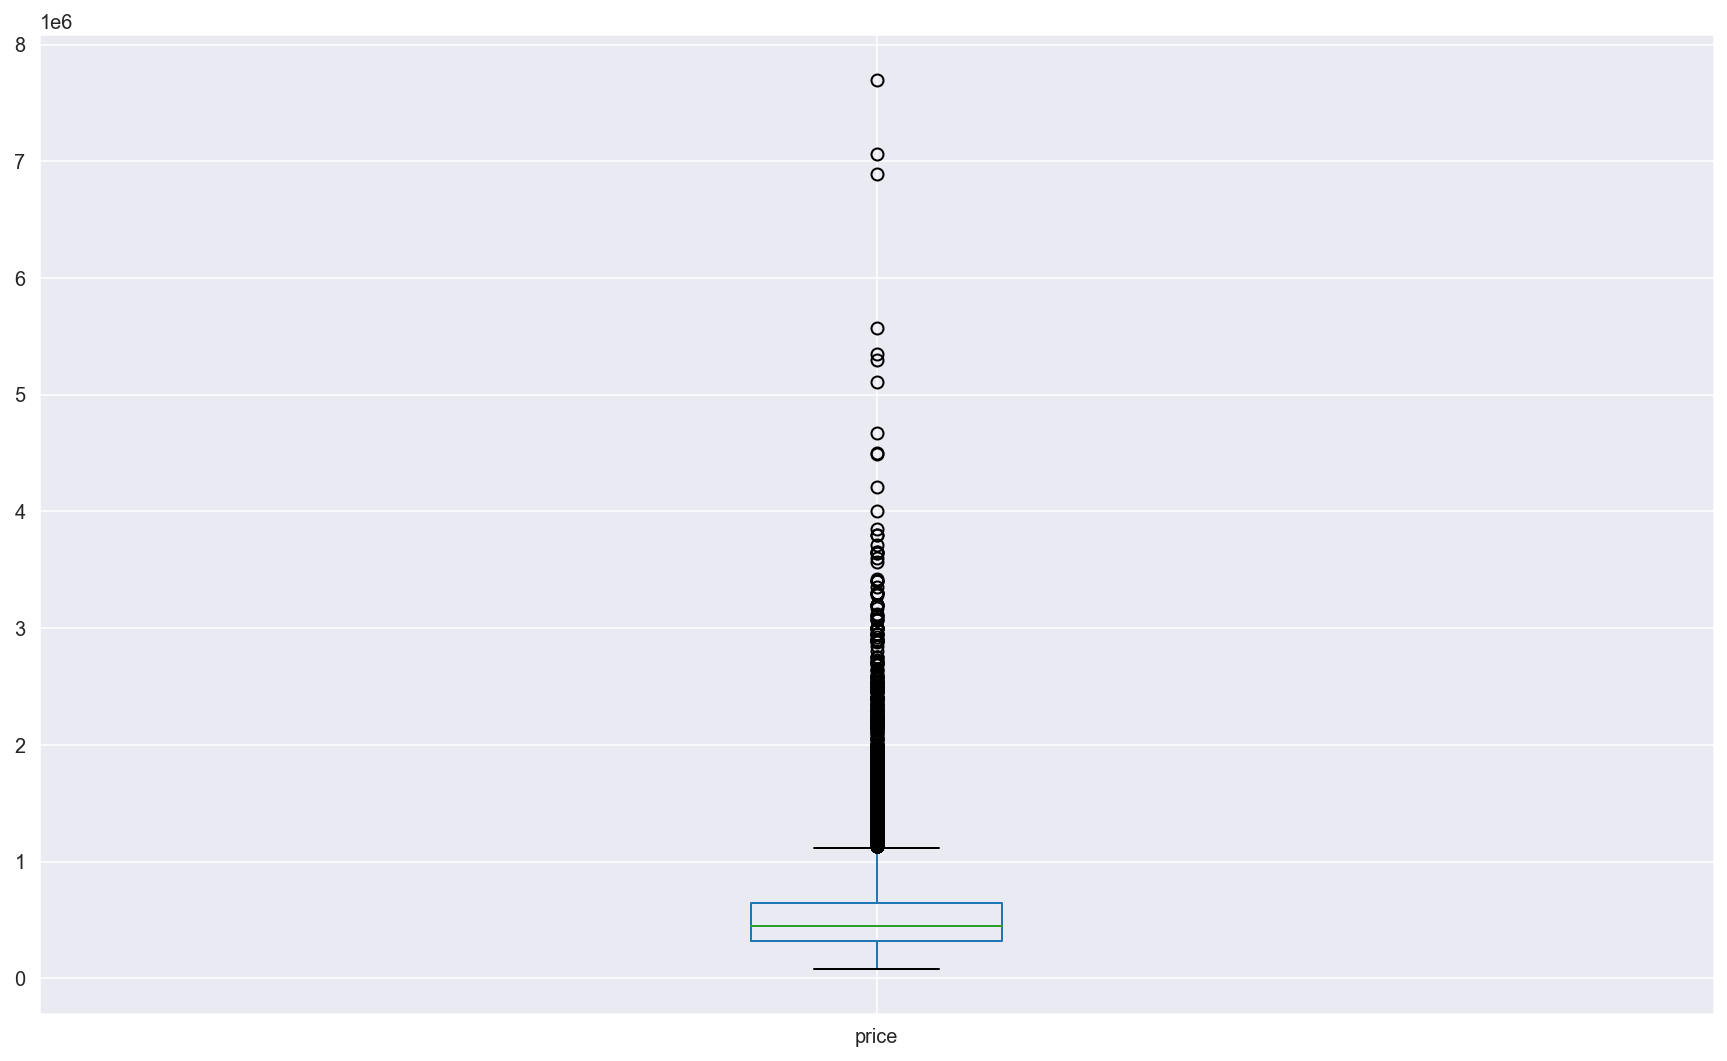

In [22]:
df.boxplot(column=['price'])

In [23]:
#Because the data is skewed to the right, transform the price data using log
df['ln_price'] = np.log(df['price'])

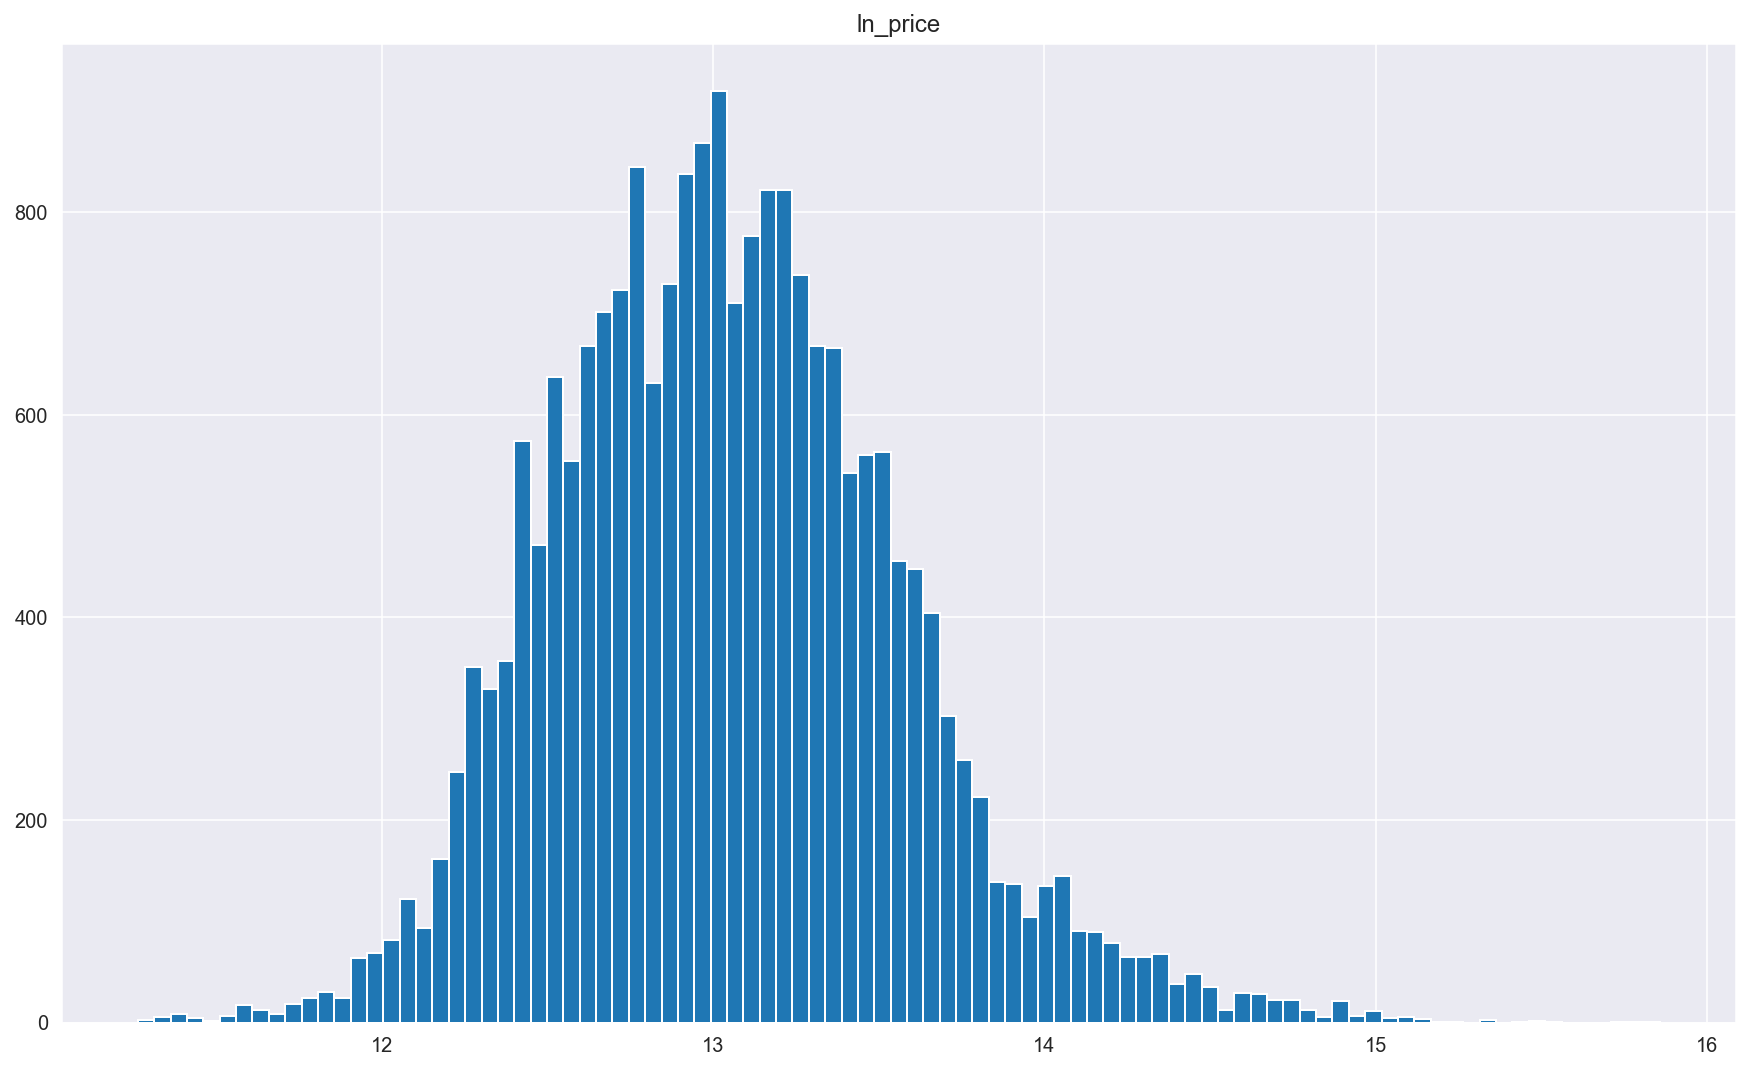

In [24]:
#view distribution of log base e for price using histogram
df.hist(column=['ln_price'], bins='auto');

<AxesSubplot:>

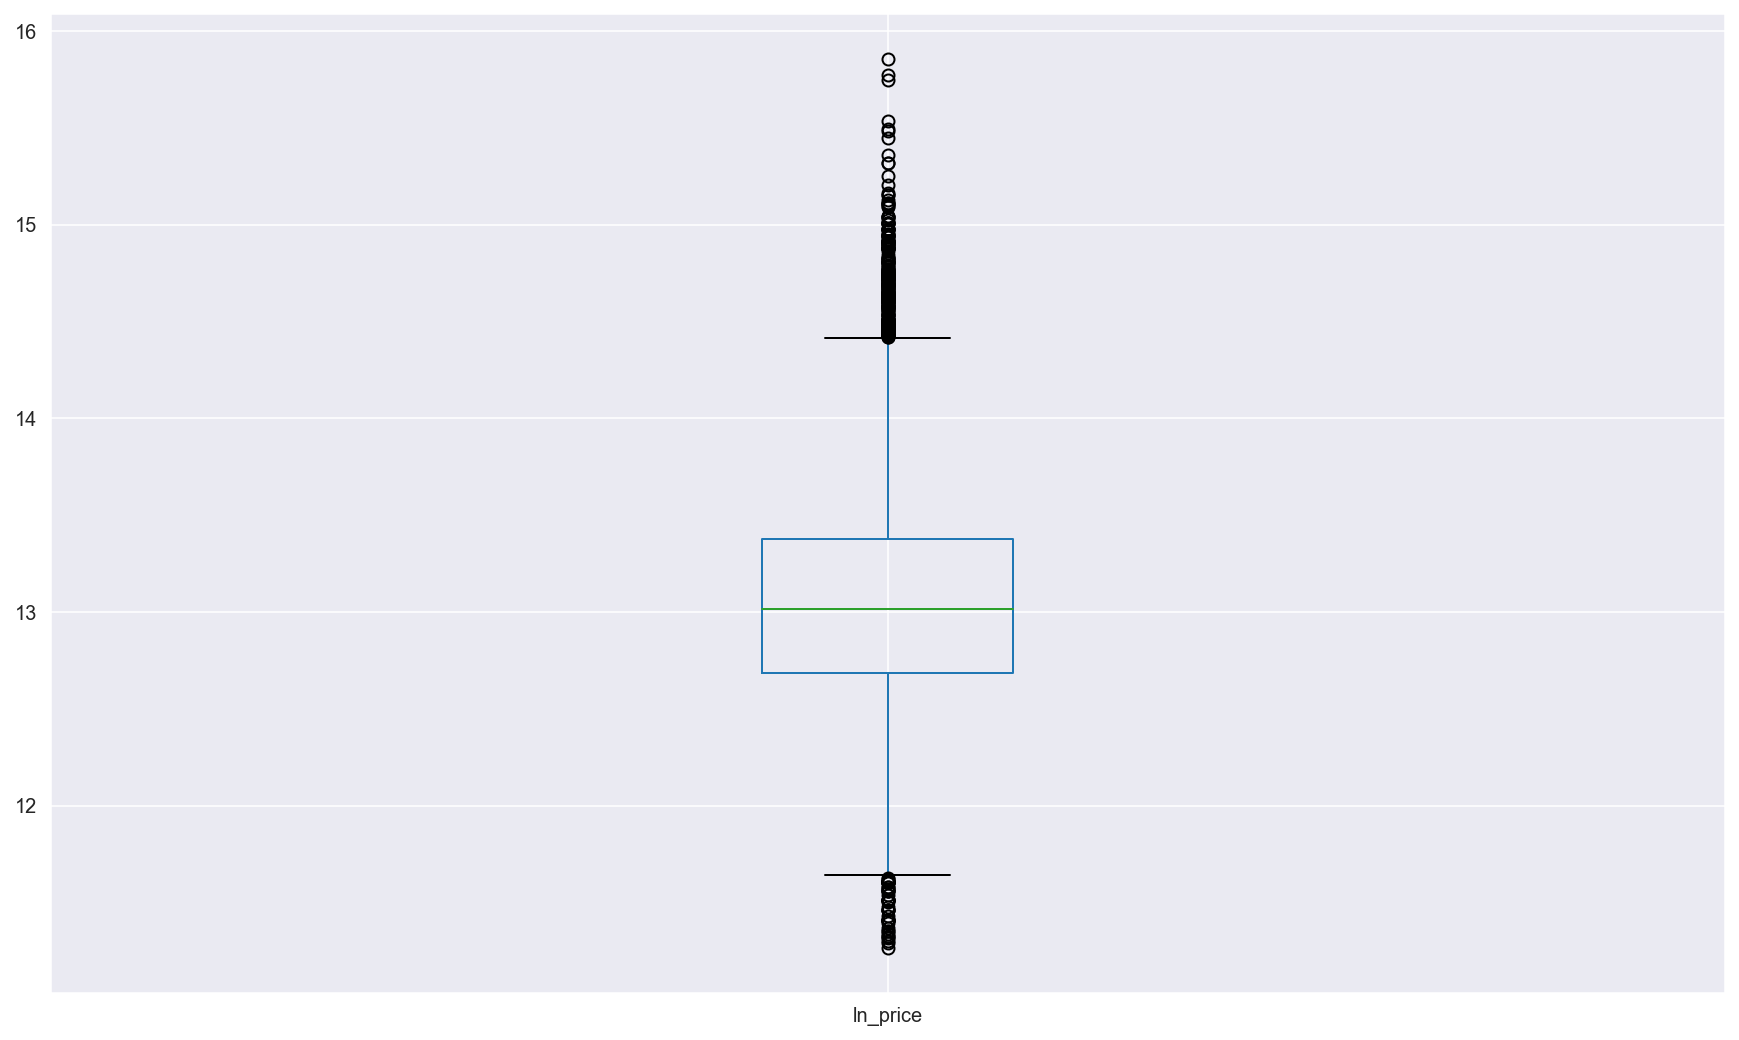

In [25]:
df.boxplot(column=['ln_price'])

### Predictors: Everything Else

In [26]:
#sns.pairplot(df)

In [27]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'if_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'month_of_date', 'age_of_house',
       'ln_price'],
      dtype='object')

In [28]:
#based on the pairplot, we can see which data are categorical and which are numeric
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

categorical = ['floors',
               'waterfront', 
               'view', 
               'condition', 
               'grade',
               'if_renovated',
               'zipcode',
               'month_of_date']

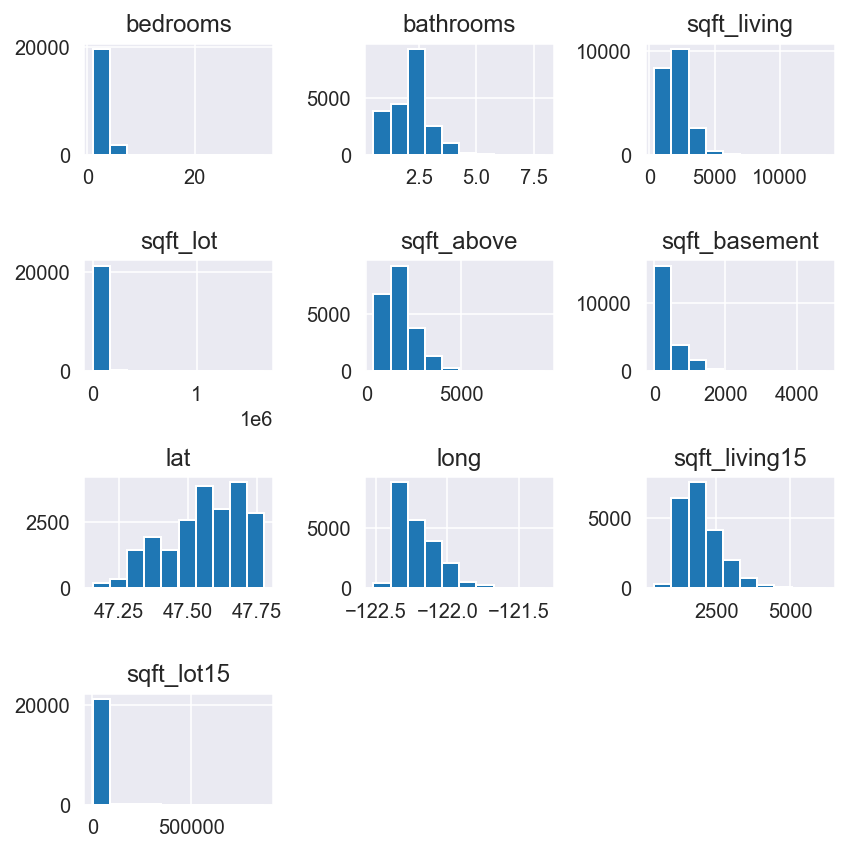

In [29]:
df[numeric].hist(figsize=[6,6]);
plt.tight_layout()
plt.show()

<ipython-input-30-e597b85bf457>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax = ax);


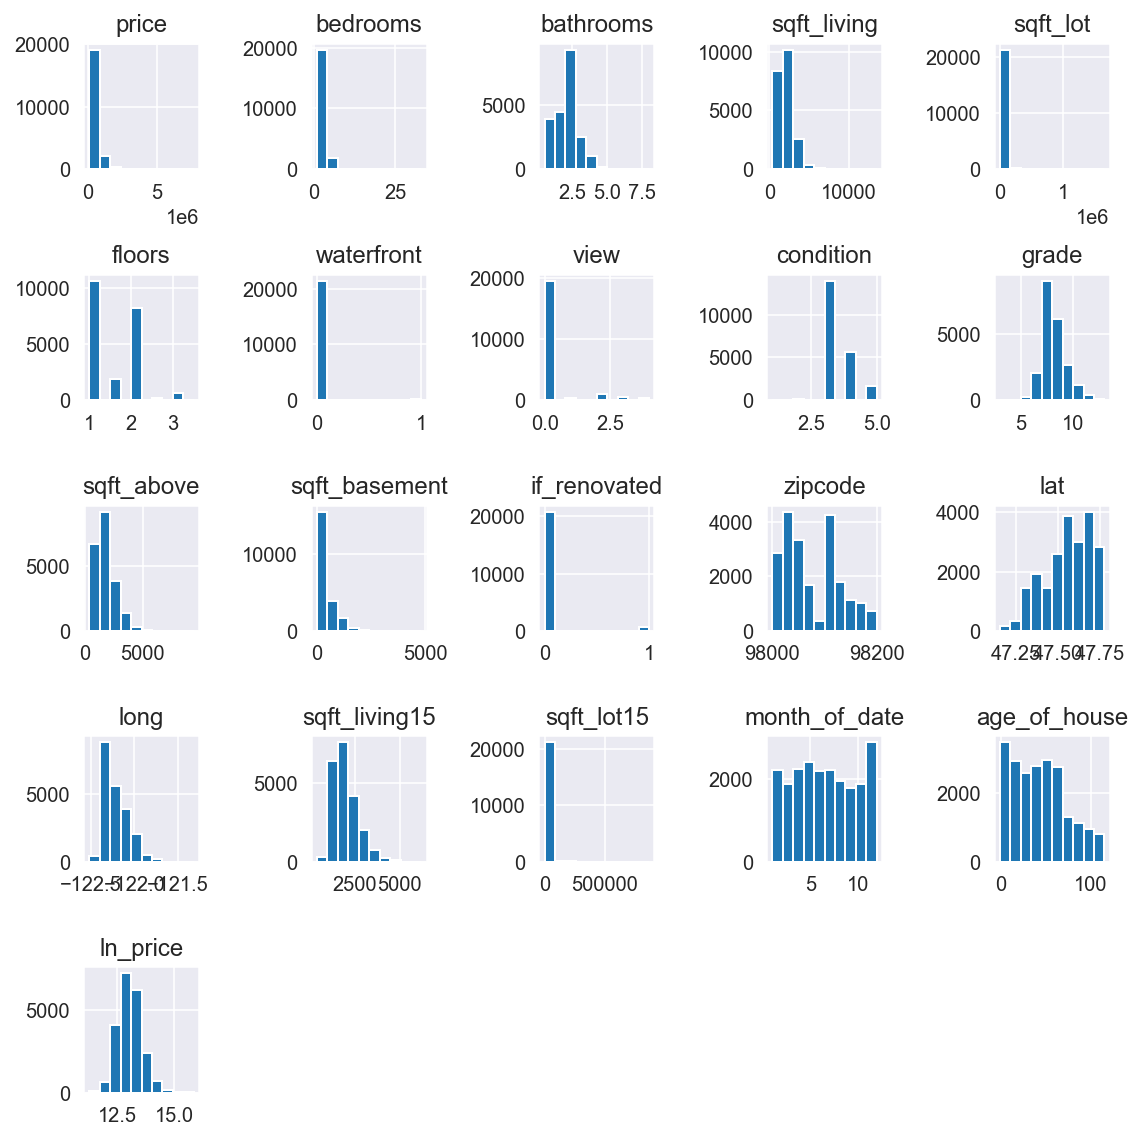

In [30]:
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
df.hist(ax = ax);
plt.tight_layout()
plt.show()

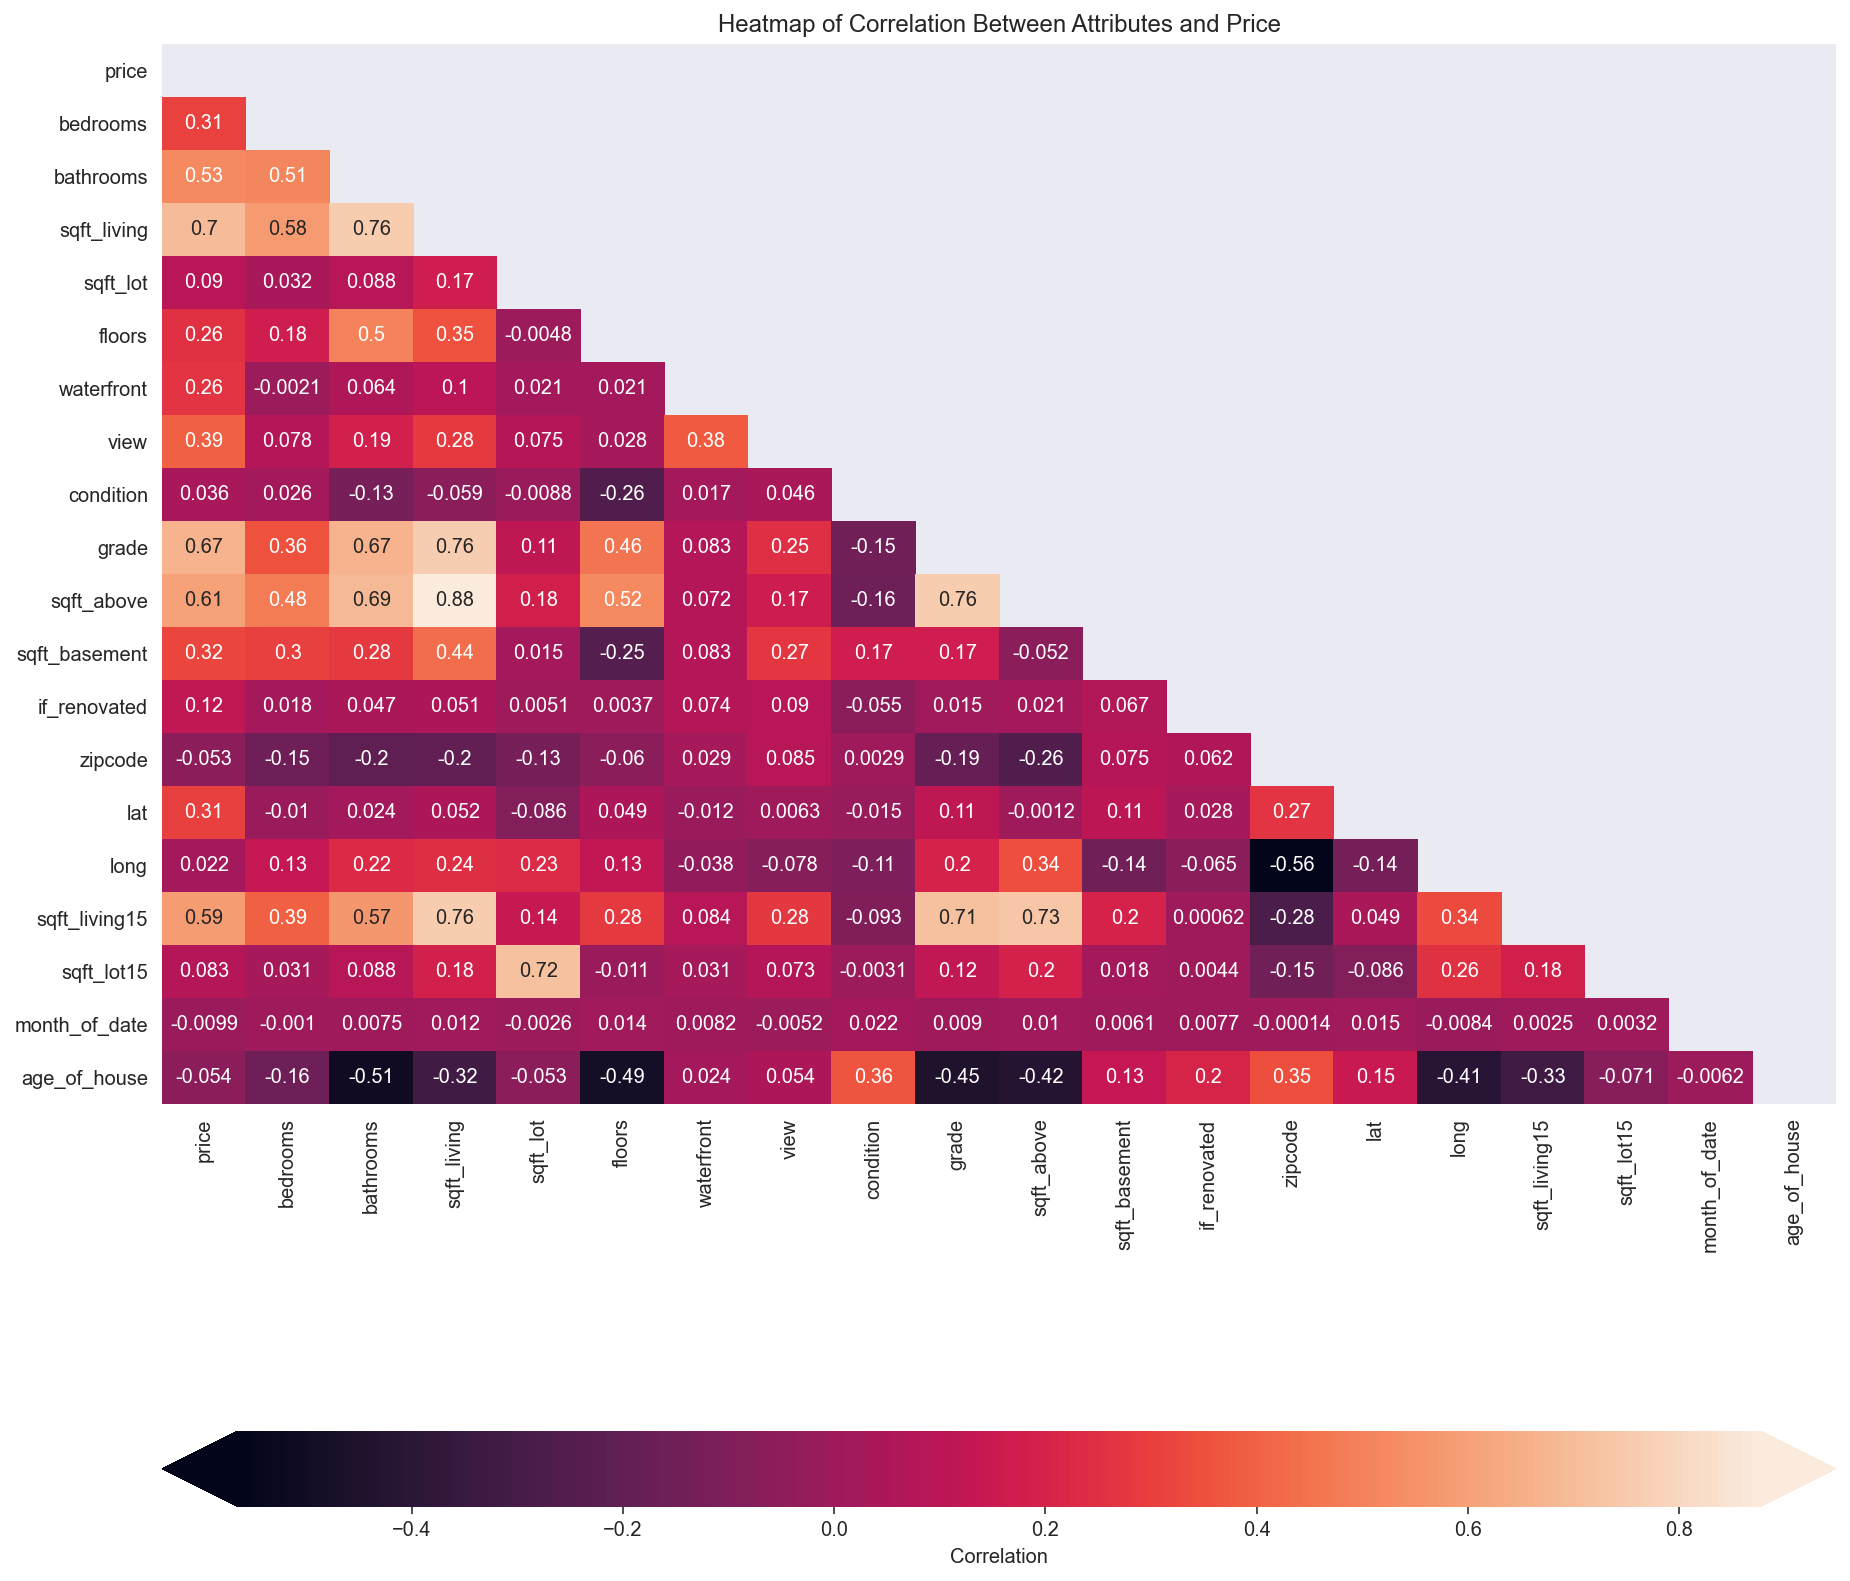

In [31]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
y = df['price']
ln_y = df['ln_price']
heatmap_data = pd.concat([y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [32]:
#reporting the correlation between price (target) and predictors
df.corr()['price'].drop(['ln_price']).map(abs).sort_values(ascending=False)

price            1.000000
sqft_living      0.701917
grade            0.667951
sqft_above       0.605368
sqft_living15    0.585241
bathrooms        0.525906
view             0.393497
sqft_basement    0.323799
bedrooms         0.308787
lat              0.306692
waterfront       0.264306
floors           0.256804
if_renovated     0.117543
sqft_lot         0.089876
sqft_lot15       0.082845
age_of_house     0.053890
zipcode          0.053402
condition        0.036056
long             0.022036
month_of_date    0.009928
Name: price, dtype: float64

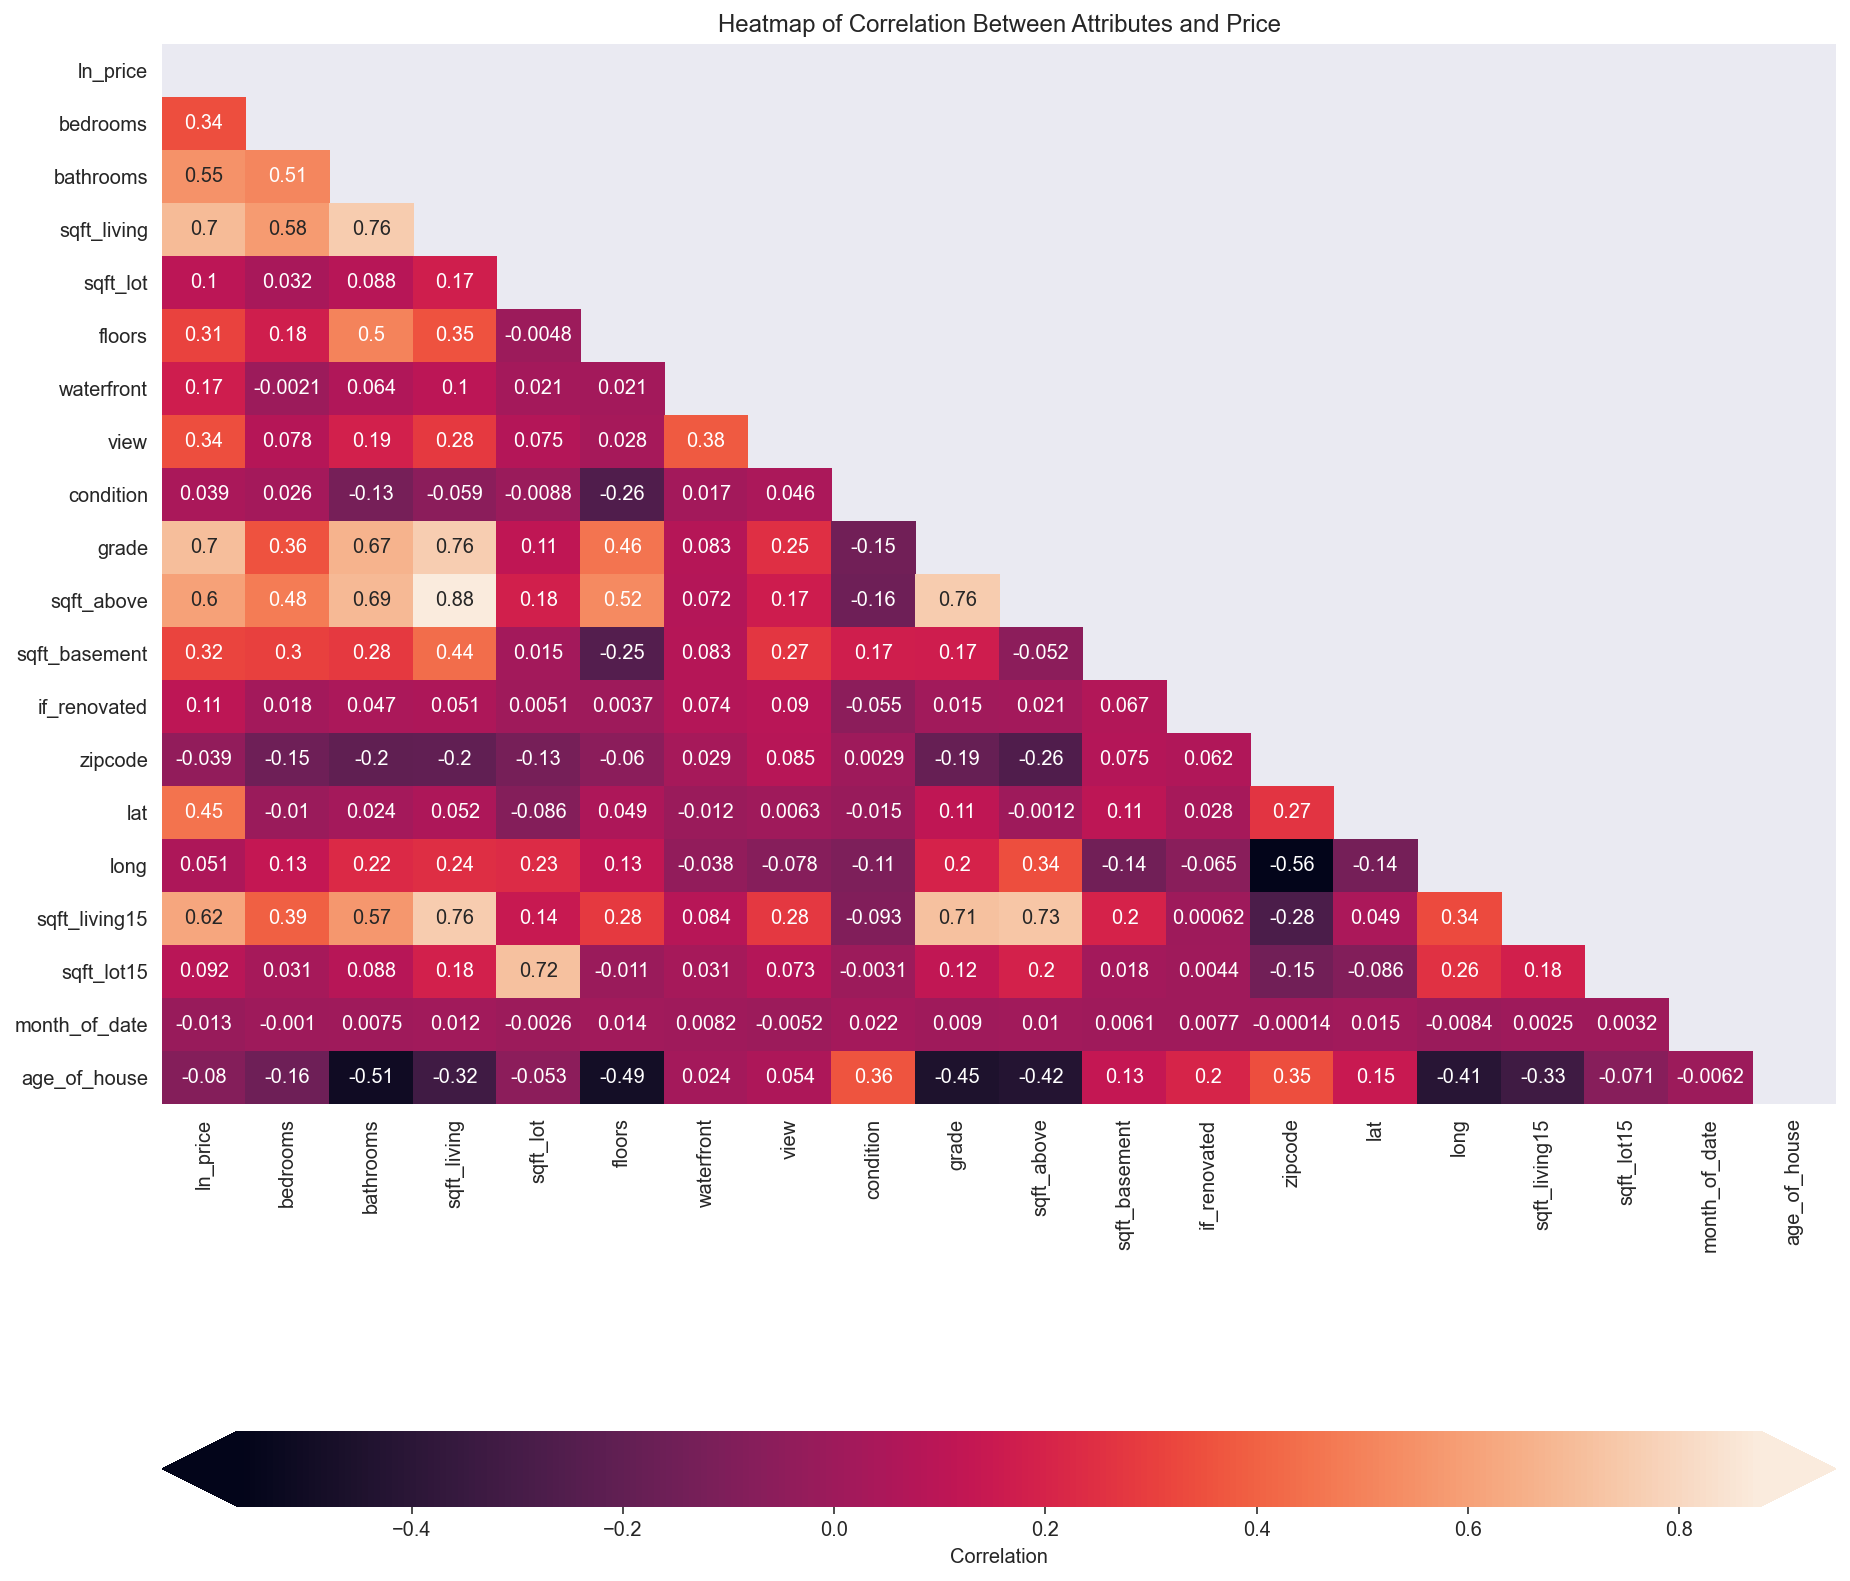

In [33]:
# Create a df with the target as the first column,
# then compute the correlation matrix
X = df.drop(['price', 'ln_price'], axis = 1)
ln_y = df['ln_price']
heatmap_data = pd.concat([ln_y, X], axis=1)
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes and Price");

In [34]:
#reporting the correlation between ln price (target) and predictors
df.corr()['ln_price'].drop(['price']).map(abs).sort_values(ascending=False)

ln_price         1.000000
grade            0.703720
sqft_living      0.695185
sqft_living15    0.619326
sqft_above       0.601579
bathrooms        0.551249
lat              0.448837
view             0.344653
bedrooms         0.343360
sqft_basement    0.316920
floors           0.310630
waterfront       0.170720
if_renovated     0.106528
sqft_lot         0.100025
sqft_lot15       0.092281
age_of_house     0.080499
long             0.050862
condition        0.038918
zipcode          0.038788
month_of_date    0.013064
Name: ln_price, dtype: float64

## Data Mainipulation

In [35]:
numeric = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           'sqft_basement',
           'lat', 
           'long',
           'sqft_living15', 
           'sqft_lot15']

to_ln = ['bedrooms', 
           'bathrooms', 
           'sqft_living', 
           'sqft_lot', 
           'sqft_above', 
           #'sqft_basement',
           'lat', 
           #'long',
           'sqft_living15', 
           'sqft_lot15'
        ]

In [36]:
for column in to_ln:
    df[column] = np.log(df[column])

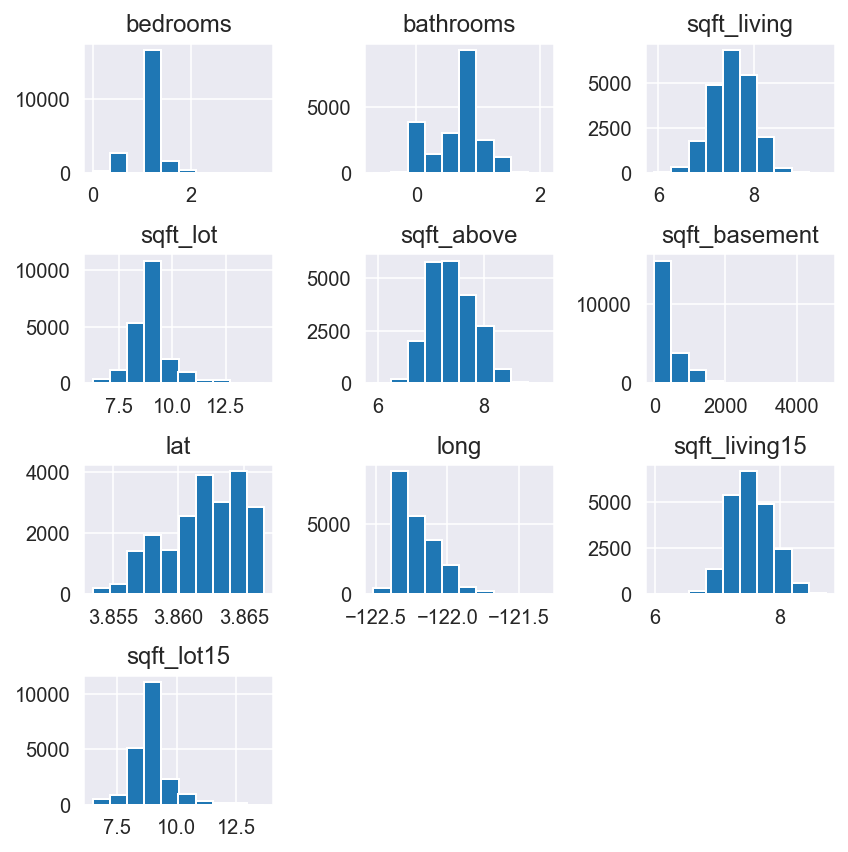

In [37]:
df[numeric].hist(figsize=[6,6]);
plt.tight_layout()
plt.show()

In [38]:
#creating a copy of base data
output = df

#dummying out categoricals defined in cleaning section
output = pd.get_dummies(output, prefix=categorical, prefix_sep='_', columns=categorical, drop_first=True)

#replace '.' with '_' in column names since sklearn LR has issues with '.'
output.columns = [x.replace(".","_") for x in output.columns]

#dropping targets out of predictors
X = output.drop(['price','ln_price'], axis=1)

#non-log transformed y values
y = output['price']

#log transformed y-values
ln_y = output['ln_price']

#scaling X values into z-scores
ss = StandardScaler()
ss.fit(X)
X_scaled = pd.DataFrame(ss.transform(X))

#scaling process loses the column names so we're adding back
X_scaled.columns = X.columns

#creating universal train test split for model comparison
X_train1, X_test1, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
X_train2, X_test2, ln_y_train, ln_y_test = train_test_split(X_scaled, ln_y, test_size=0.20, random_state=42)

### Formulas and useful objects

In [39]:
def cross_val(estimator,X=X,y=y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [40]:
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [41]:
def score_model(model,Xtrain,Xtest,ytrain,ytest):
    return model.score(Xtrain, ytrain), model.score(Xtest, ytest)

In [42]:
def model_summary(train,test,diff):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-sqaured value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

## Baseline Model

### Baseline: Target Price

In [43]:
#create a dummy regressor model based on the target as price
baseline_model = DummyRegressor(strategy='mean')
baseline_model.fit(X_train1,y_train);

In [44]:
#setting up cross validation for price in a different way (x3)
bmodel_cval = cross_val(baseline_model,
                        random_state=0)

bmodel_cval_summary = cval_summary(bmodel_cval[0],
                                   bmodel_cval[1],
                                   (abs(bmodel_cval[0]-bmodel_cval[1])))
bmodel_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00017'

In [45]:
baseline_scores = score_model(baseline_model,
                              X_train1,
                              X_test1,
                              y_train,
                              y_test)

baseline_summary = model_summary(baseline_scores[0],
                                 baseline_scores[1],
                                 abs(baseline_scores[0]-baseline_scores[1]))
baseline_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00029'

### Baseline: Target Log-transformed Price

In [46]:
#create `a dummy regressor model based on the target as price
baseline_ln_model = DummyRegressor(strategy='mean')
baseline_ln_model.fit(X_train2,ln_y_train);

In [47]:
bmodel_ln_cval = cross_val(baseline_ln_model,
                           y=ln_y,
                           random_state=0)

bmodel_ln_cval_summary = cval_summary(bmodel_ln_cval[0],
                                      bmodel_ln_cval[1], 
                                      abs(bmodel_ln_cval[0]-bmodel_ln_cval[1]))
bmodel_ln_cval_summary

'The median R-squared values for the train sets were 0.0, the median R-squared values for the test sets were -0.0. These values resulted in a differential of 0.00029'

In [48]:
baseline_ln_scores = score_model(baseline_ln_model,
                                 X_train2,
                                 X_test2,
                                 ln_y_train,
                                 ln_y_test)

baseline_ln_summary = model_summary(baseline_ln_scores[0],
                                    baseline_ln_scores[1],
                                    abs(baseline_ln_scores[0]-baseline_ln_scores[1]))
baseline_ln_summary

'The R-squared value for the train set was 0.0, and the R-sqaured value for the test set was -0.0. These values resulted in a differential of 0.00022'

### Summary

After running cross validation with both of our baseline models to ensure data integrity, we found from the results of our regression R-squared scores that the fit of the data we found that the cval, train and test scores were all near 0. This is to be expected of the baseline model due to it's horizontal nature. Exactly 0% of the variation in y train is predicted by a horizontal line through the mean and 100% of it is due to variance.

>The miniscule inscrease in R-squared for the test set is due to the slight change in mean from the train to test sets.

It is also worthwhile to mention that the log-transformed data performed slightly better on the test set than its non-transformed counterpart

## Model 1

Model 1 uses a multiple linear regression model of the data using all parameters, including the dummied out categorical parameters.

### Model 1: Target Price

In [49]:
#create linear regression model for price and setting up cross validation 
model1 = LinearRegression()
model1.fit(X_train1, y_train);

In [50]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                           random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.83, the median R-squared values for the test sets were 0.828. These values resulted in a differential of 0.00222'

In [51]:
model1_scores = score_model(model1,
                            X_train1,
                            X_test1,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]))
model1_summary

'The R-squared value for the train set was 0.838, and the R-sqaured value for the test set was 0.798. These values resulted in a differential of 0.03989'

### Model 1: Target Log-transformed Price

In [52]:
#create linear regression model for ln price
model1_ln= LinearRegression()
model1_ln.fit(X_train2, ln_y_train);

In [53]:
y_predicted = model1_ln.predict(X_test2)

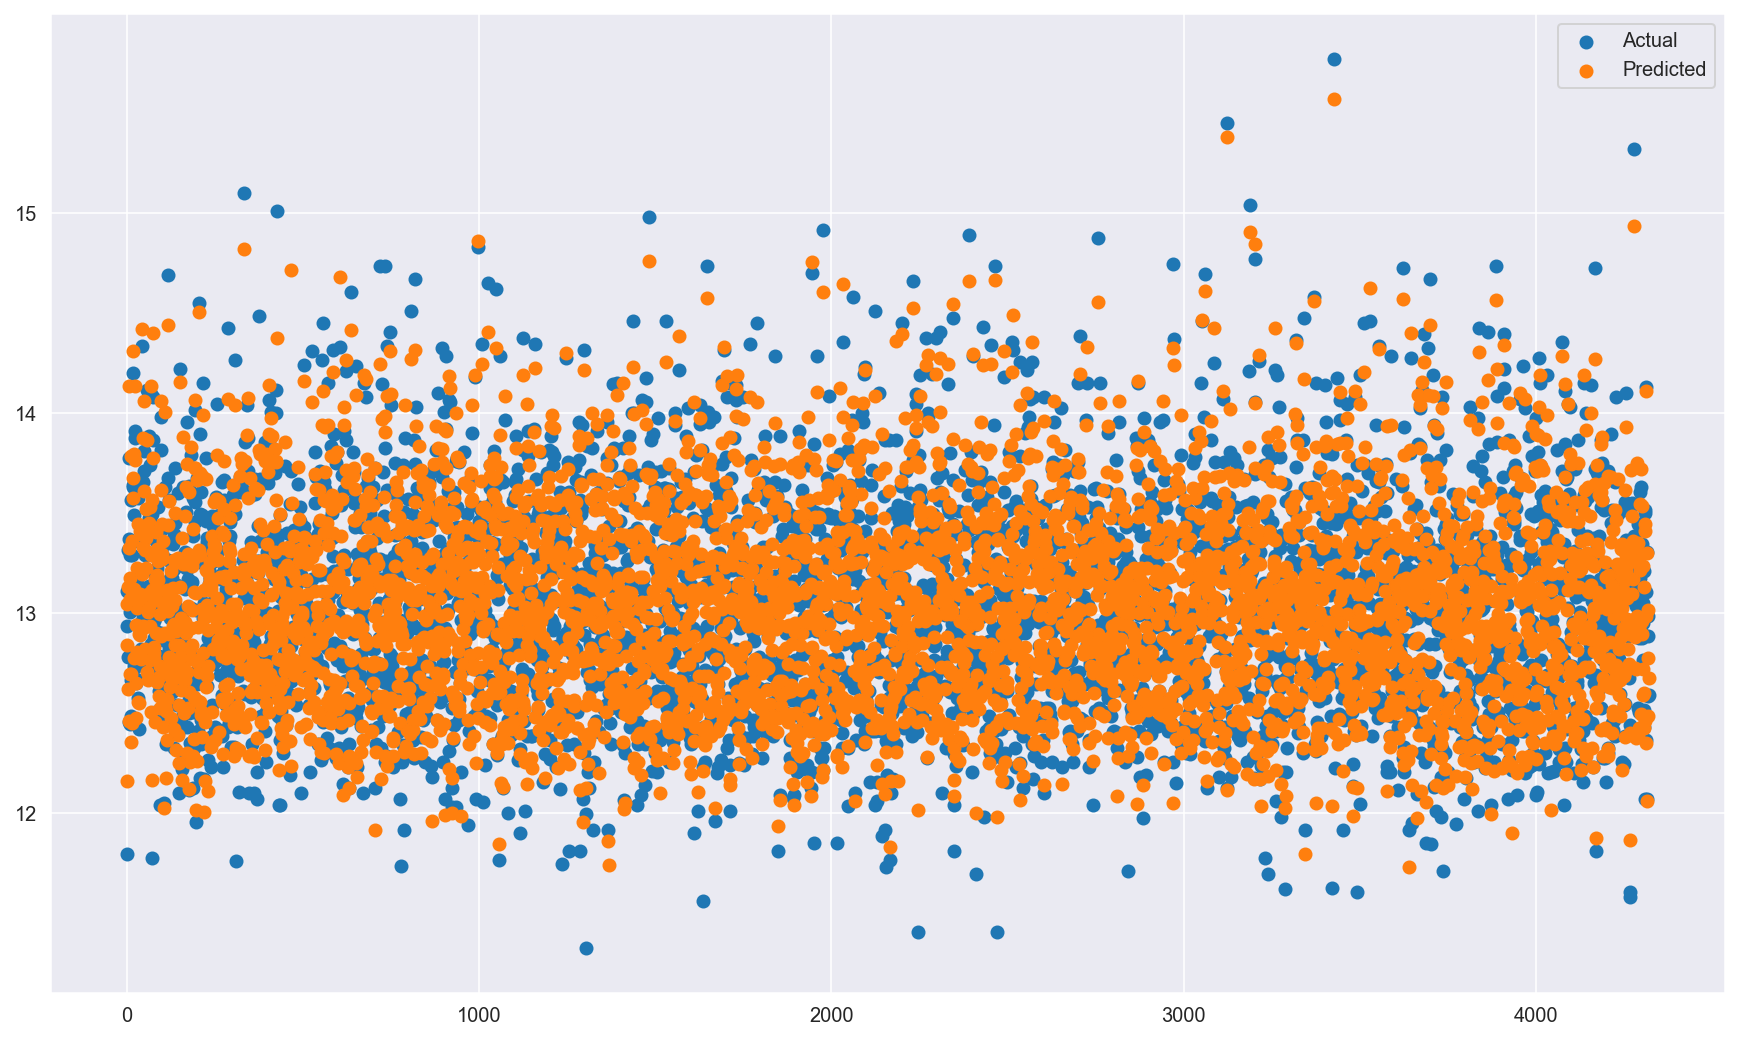

In [54]:
plt.scatter(list(range(len(ln_y_test))), ln_y_test, label='Actual')
plt.scatter(list(range(len(ln_y_test))), y_predicted, label='Predicted')
plt.legend();

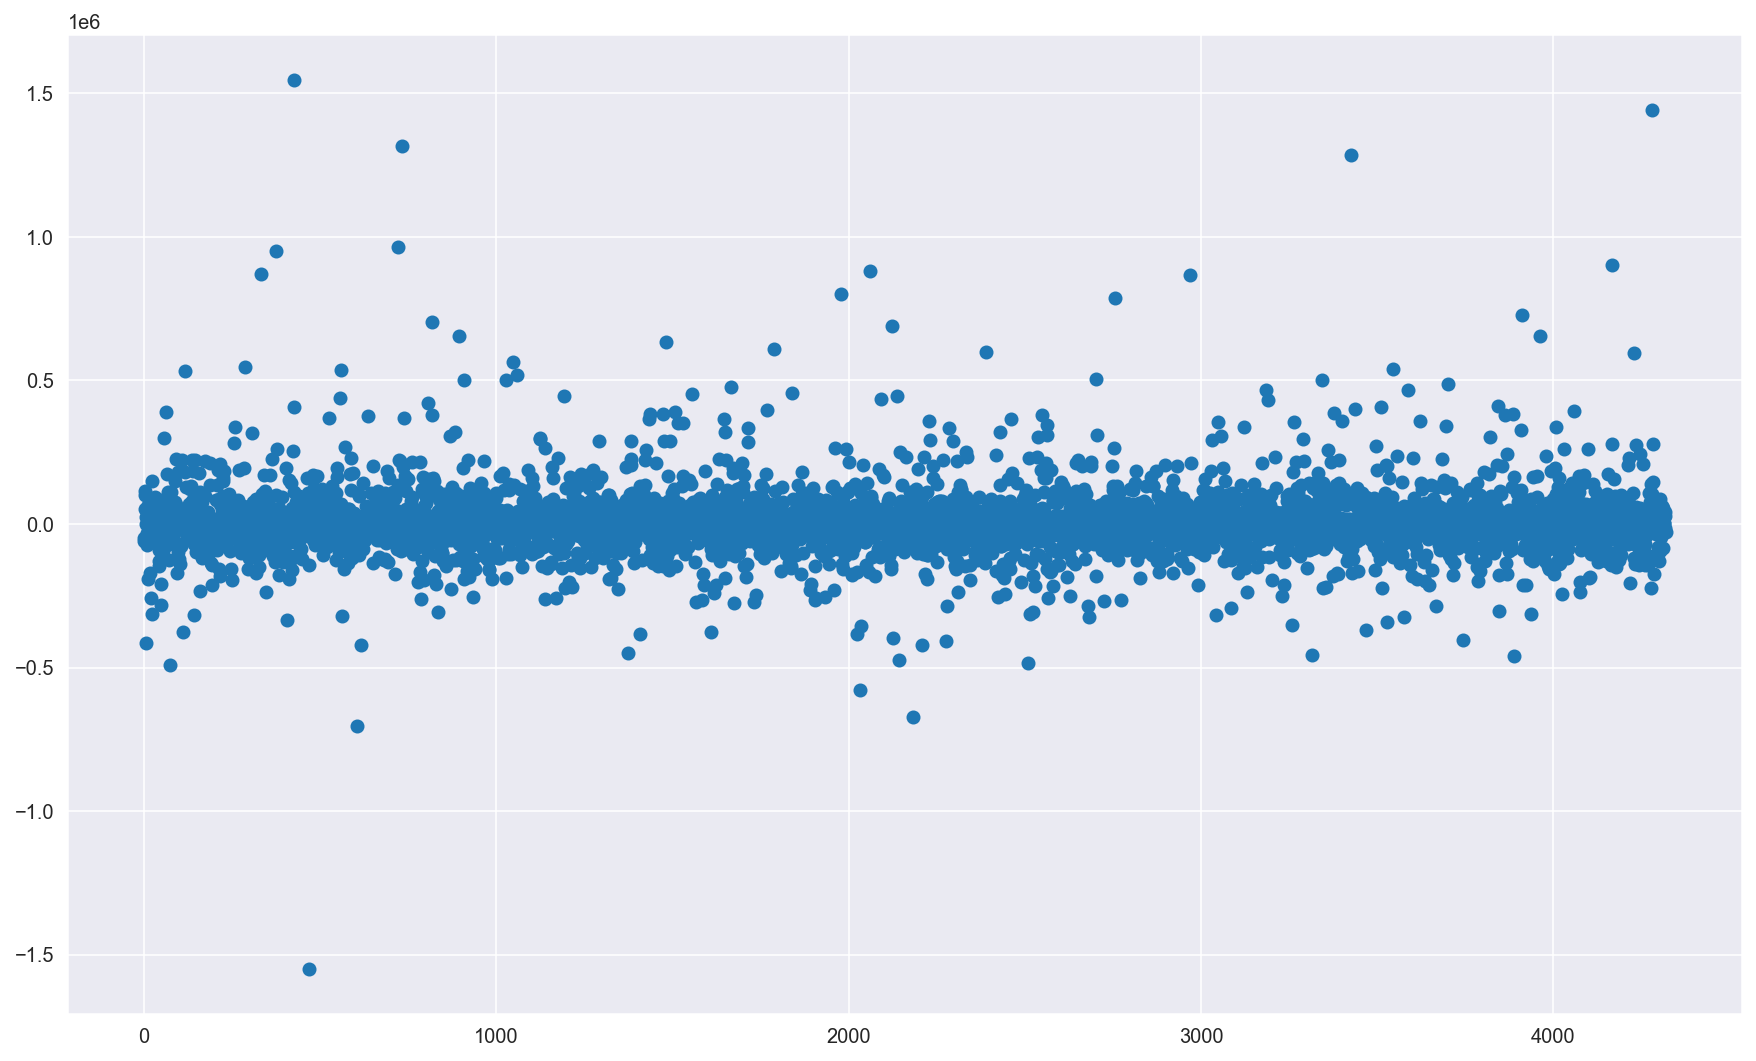

In [55]:
y_diff = np.exp(ln_y_test) - np.exp(y_predicted)
plt.scatter(list(range(len(ln_y_test))), y_diff)

In [56]:
#setting up cross validation for ln price in a different way (x3)
model1_ln_cval = cross_val(model1_ln,
                           y = ln_y,
                           random_state=0)

model1_ln_cval_summary = cval_summary(model1_ln_cval[0],
                                   model1_ln_cval[1],
                                   abs(model1_ln_cval[0]-model1_ln_cval[1]))
model1_ln_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [57]:
#find the test score using the linear model
model1_ln_scores = score_model(model1_ln,
                             X_train2,
                             X_test2,
                             ln_y_train,
                             ln_y_test)

model1_ln_summary = model_summary(model1_ln_scores[0],
                                  model1_ln_scores[1],
                                  abs(model1_ln_scores[0]-model1_ln_scores[1]))
model1_ln_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00362'

### Summary

We see that both variations of Model 1 output a higher R-squared than value than either of the Baseline models with values ranging between 0.810 and 0.880. In addition, Model 1 train and test scores varied by less than 5%. 

>The version of Model 1 that used the log-transformed price data had a .07 higher R-squared value than the untransformed price data model as well as a  .03 lower differential between train and test sets. For this reason we are going to stop using the regular price data and move forward with the transformed data.

The cross validation performed identically between these two features and did not drastically differ from our test statistics (R-squared).

In [58]:
#Overwriting non-transformed train/test splits, to avoid confusion we will switch to simpler names
X_train = X_train2
X_test = X_test2
y_train = ln_y_train
y_test = ln_y_test

## Model 2

In Model 2 we drop features that had a relatively high p-value (alpha = 0.05) from Model 1 OLS to look for improvement in model fit.

### Filtering by p-value

In [116]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(output.drop(['ln_price'], axis=1).columns)

#set formula
formula = target + '~' +columns

#create the OLS
model1_ols = ols(formula, output).fit()

#create a dataframe for the parameters and pvalues
results = pd.DataFrame(model1_ols.pvalues)
results.reset_index(inplace=True)

#rename the columns
results.rename(columns={'index': 'parameter', 0: 'pvalue'}, inplace=True)

#create a list of parameters that have a pvalue < 0.05
parameters = list(results[results['pvalue'] < 0.05]['parameter'])

#the intercept parameter is not needed 
parameters.remove('Intercept')

In [117]:
model1_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     2723.
Date:                Wed, 14 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:13:54   Log-Likelihood:                 13034.
No. Observations:               21597   AIC:                        -2.583e+04
Df Residuals:                   21479   BIC:                        -2.489e+04
Df Model:                         117                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -84.9088     10.403     -8.162      0.000    -105.299     -64.519
price             7.728e-07   5.98e-09    129.265      0.000    7.61e-07    7.85e-07
bedrooms            -0.0287      0.005     -6.380      0.000      -0.038      -0.020
bathrooms            0.0325      0.004      7.497      0.000       0.024       0.041
sqft_living          0.4728      0.013     35.899      0.000       0.447       0.499
sqft_lot             0.0462      0.003     17.168      0.000       0.041       0.051
sqft_above          -0.2117      0.012    -17.565      0.000      -0.235      -0.188
sqft_basement       -0.0002   6.25e-06    -25.182      0.000      -0.000      -0.000
lat                 16.0603      2.493      6.442      0.000      11.174      20.947
long                -0.2630      0.038     -6.911      0.000      -0.338      -0.188
sqft_living15        0.1110      0.005     22.296      0.000       0.101       0.121
sqft_lot15          -0.0094      0.003     -3.172      0.002      -0.015      -0.004
age_of_house     -1.097e-05   5.92e-05     -0.185      0.853      -0.000       0.000
floors_1_5           0.0209      0.004      5.555      0.000       0.014       0.028
floors_2_0           0.0007      0.003      0.222      0.824      -0.006       0.007
floors_2_5          -0.0490      0.011     -4.399      0.000      -0.071      -0.027
floors_3_0          -0.0314      0.007     -4.444      0.000      -0.045      -0.018
floors_3_5          -0.0821      0.051     -1.625      0.104      -0.181       0.017
waterfront_1        -0.0290      0.014     -2.044      0.041      -0.057      -0.001
view_1               0.0510      0.008      6.728      0.000       0.036       0.066
view_2               0.0543      0.005     11.699      0.000       0.045       0.063
view_3               0.0717      0.006     11.234      0.000       0.059       0.084
view_4               0.0790      0.010      8.148      0.000       0.060       0.098
condition_2          0.0791      0.027      2.948      0.003       0.027       0.132
condition_3          0.1957      0.025      7.828      0.000       0.147       0.245
condition_4          0.2190      0.025      8.755      0.000       0.170       0.268
condition_5          0.2487      0.025      9.874      0.000       0.199       0.298
grade_4             -0.4230      0.136     -3.121      0.002      -0.689      -0.157
grade_5             -0.3965      0.133     -2.973      0.003      -0.658      -0.135
grade_6             -0.3215      0.133     -2.414      0.016      -0.583      -0.060
grade_7             -0.2497      0.133     -1.875      0.061      -0.511       0.011
grade_8             -0.1843      0.133     -1.383      0.167      -0.445       0.077
grade_9             -0.1402      0.133     -1.051      0.293      -0.401       0.121
grade_10            -0.

### Fitting the model

In [61]:
#create linear regression model for price and setting up cross validation (x3)
model2 = LinearRegression()
model2.fit(X_train[parameters], y_train);

### Cross-Validation Step

In [62]:
#setting up cross validation for ln price in a different way (x3)
model2_cval = cross_val(model2,
                        y=ln_y,
                        random_state=0)

model2_cval_summary = cval_summary(model2_cval[0],
                                   model2_cval[1],
                                   abs(model2_cval[0]-model2_cval[1]))
model2_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

### Model Validation

In [63]:
#find the test score using the linear model
model2_scores = score_model(model2,
                             X_train[parameters],
                             X_test[parameters],
                             y_train,
                             y_test)

model2_summary = model_summary(model2_scores[0],
                                  model2_scores[1],
                                  abs(model2_scores[0]-model2_scores[1]))
model2_summary

'The R-squared value for the train set was 0.878, and the R-sqaured value for the test set was 0.873. These values resulted in a differential of 0.00523'

### Summary

Our fit on the data has dropped drastically by removing features containing p-values greater than 0.05. In light of this signifigant decrease in accuracy we will still be relying on our "best model", which is currently model 1.

# Model 1: Assumption Tests


 Jarque-Bera ----
452683.80173985136

 Prob ----
0.0

 Skew ----
-1.7193776119830477

 Kurtosis ----
25.163637624679897


<ipython-input-4-c4f5b2528f3c>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


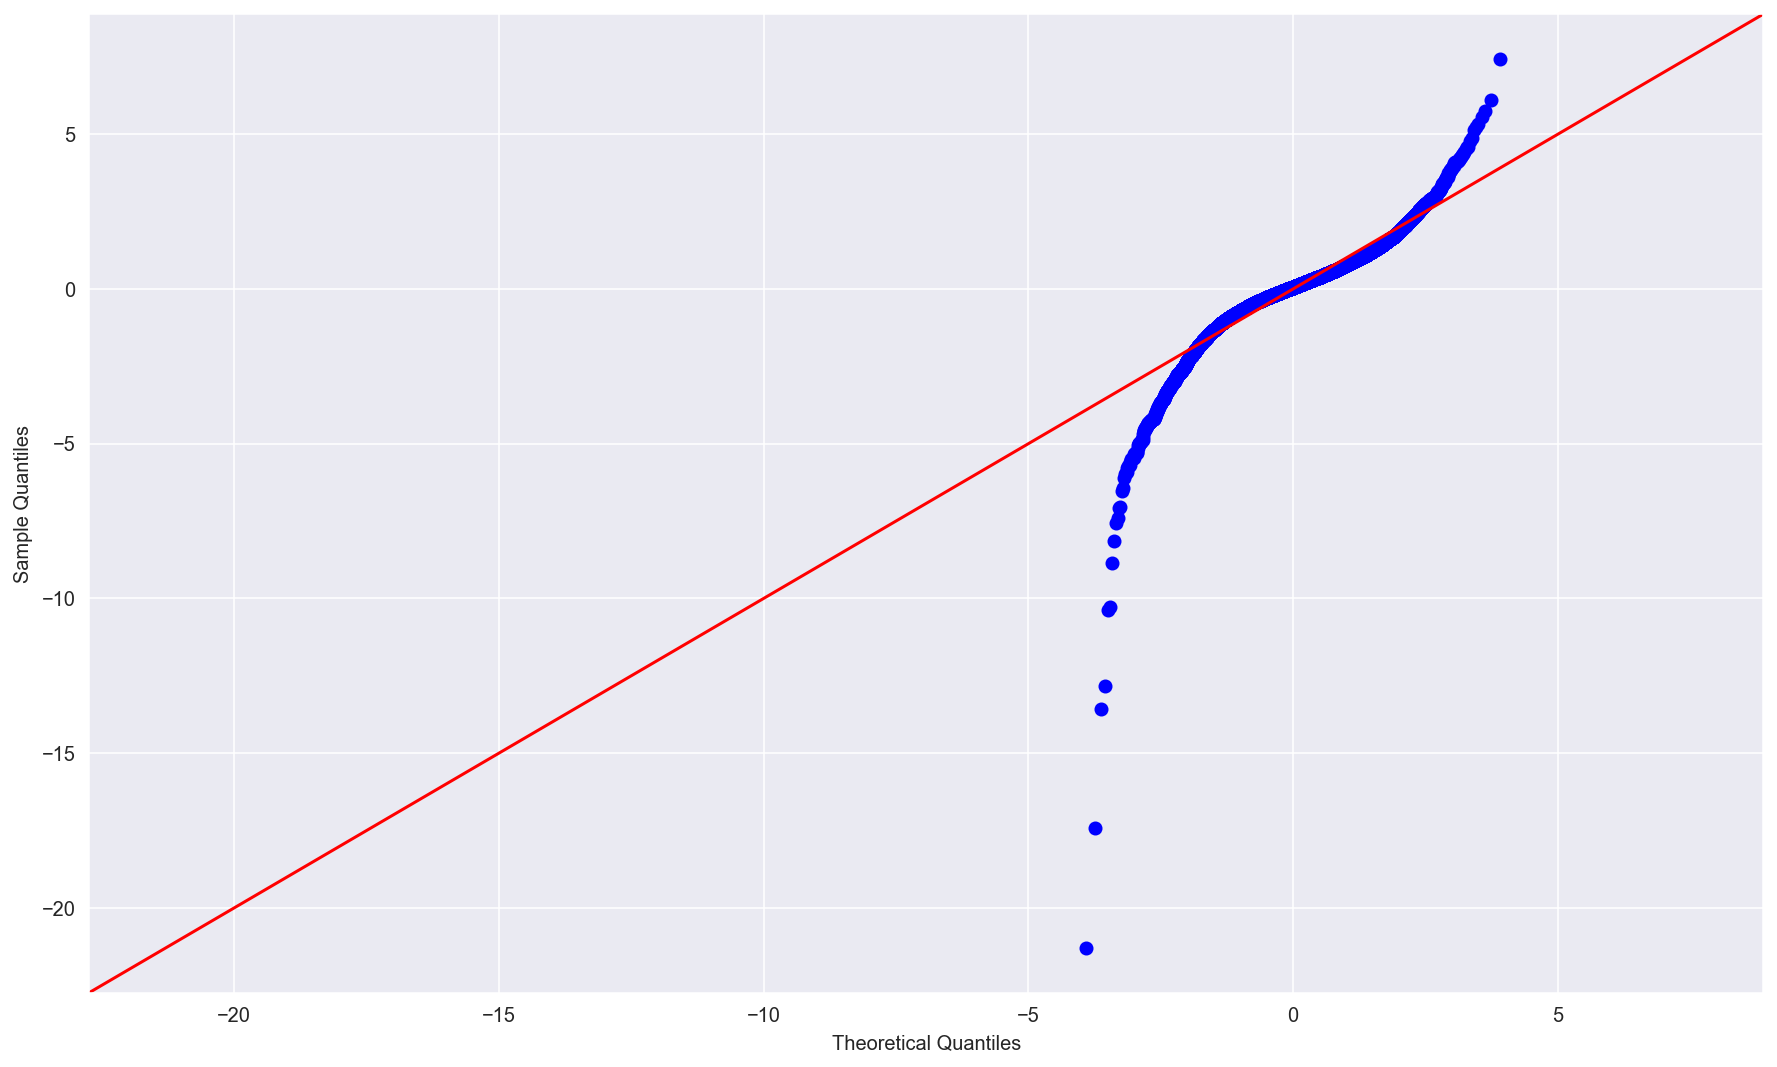

In [118]:
normality(model1_ols)

<ipython-input-65-cf09e3491b0c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


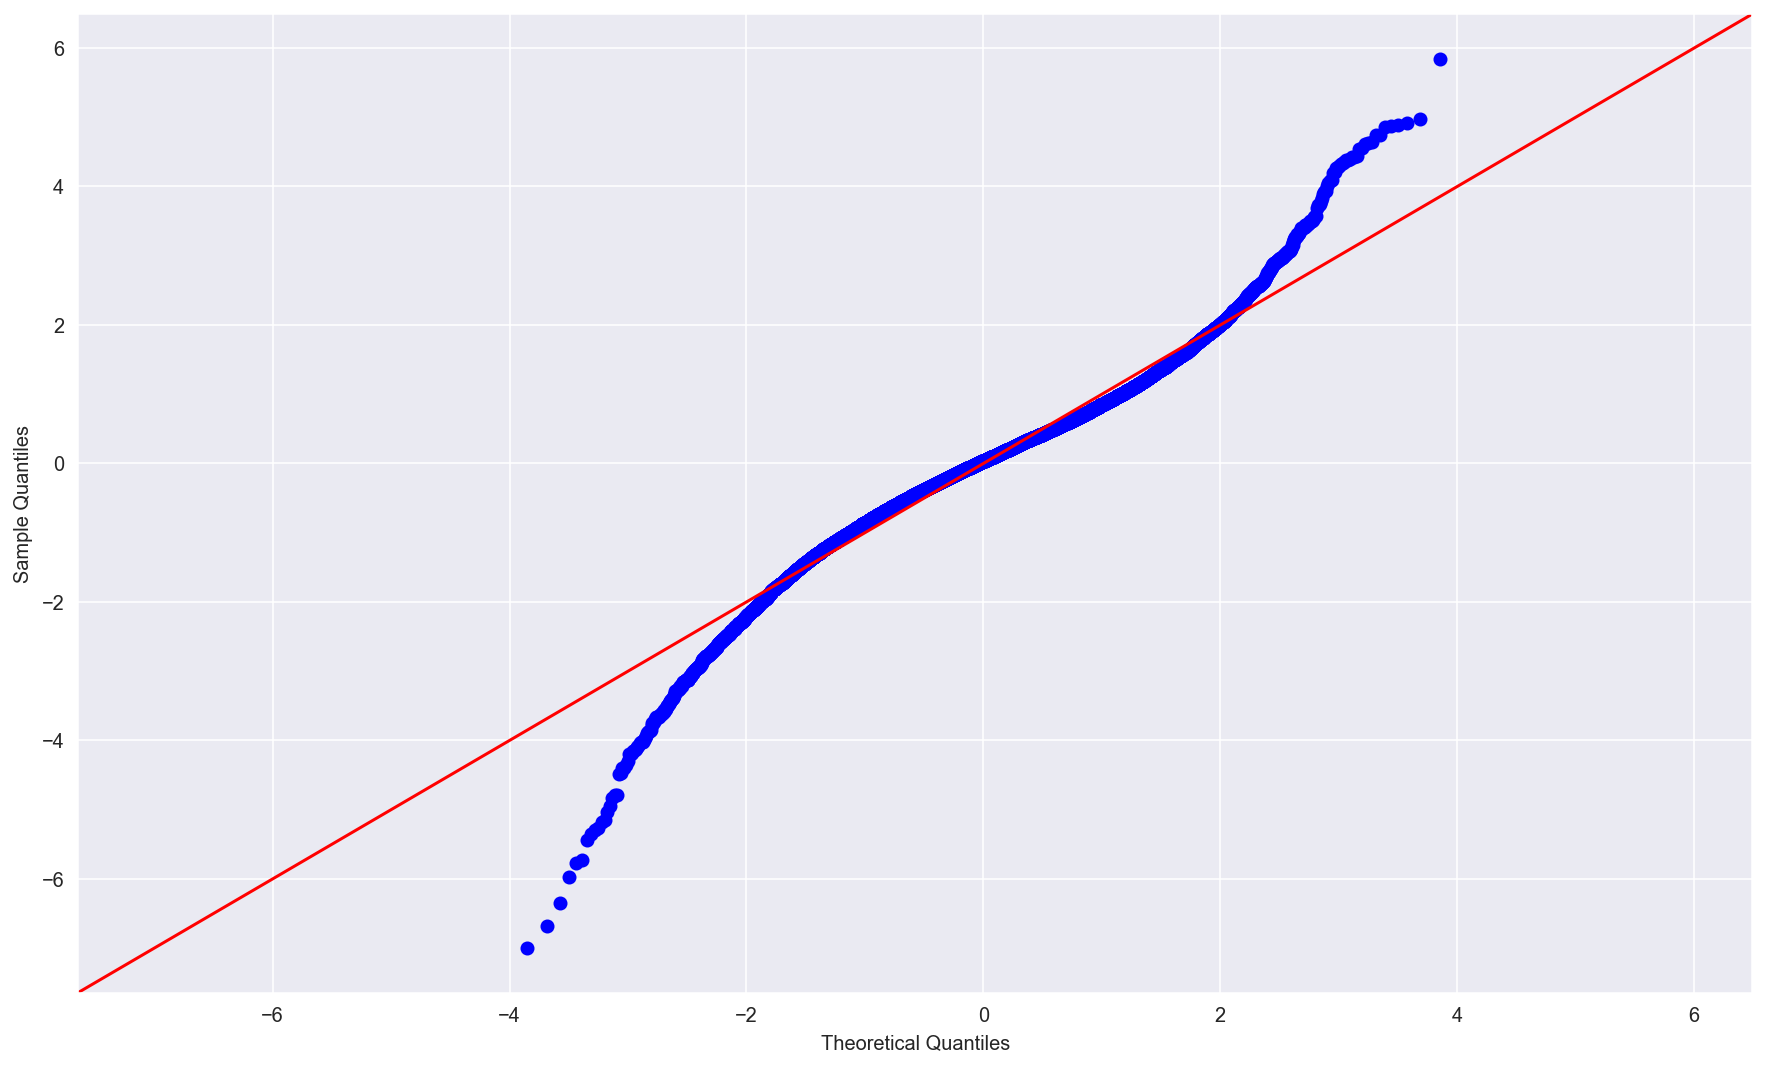

In [65]:
residuals = model1_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [66]:
#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 5395.970380425714),
 ('Prob', 0.0),
 ('Skew', -0.21294793261389752),
 ('Kurtosis', 5.704499464917761)]


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.656417e+03
p-value                        1.176872e-270
f-value                         1.568671e+01
f p-value                      1.298747e-286

 Goldfeld-Quandt test ----
                value
F statistic  0.971864
p-value      0.906125

 Residuals plots ----


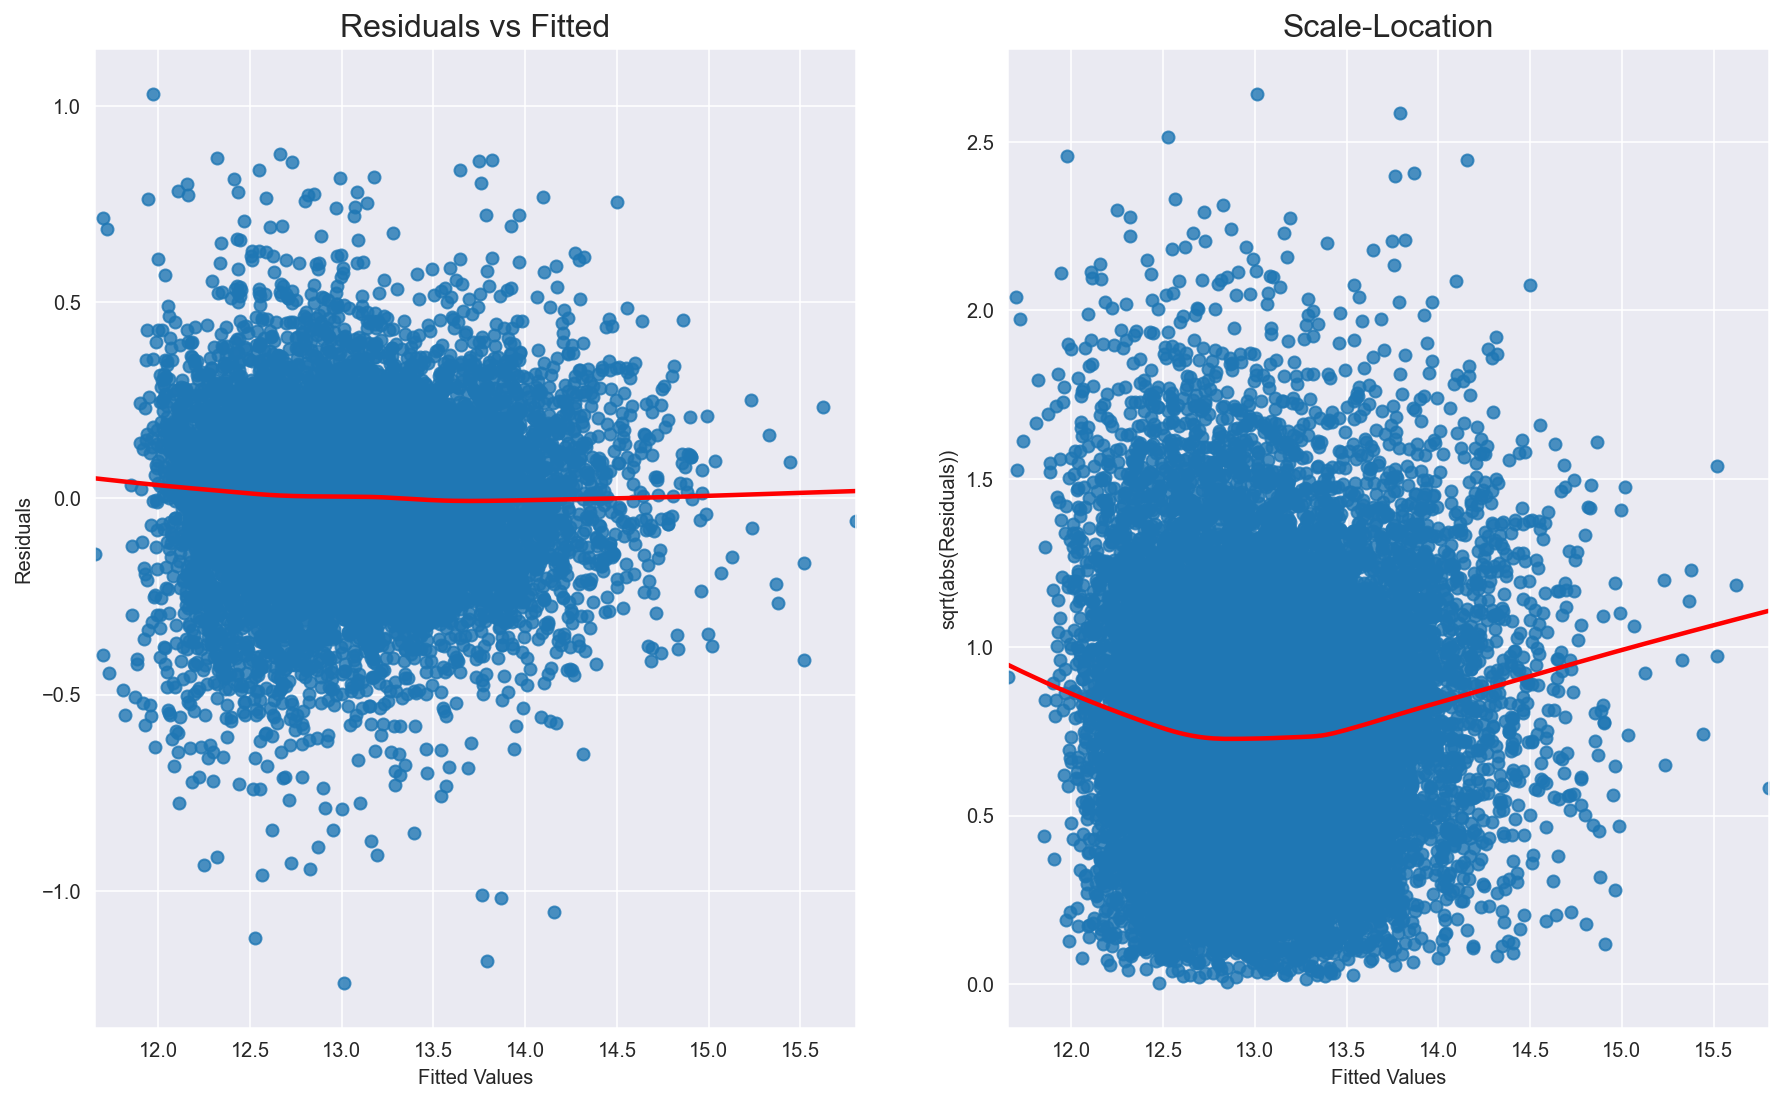

In [67]:
homoscedasticity_test(model1_ols)

# Model 2: Assumption Tests

In [115]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(output[parameters].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model2_ols = ols(formula, output).fit()

<ipython-input-69-7bf03b8da824>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


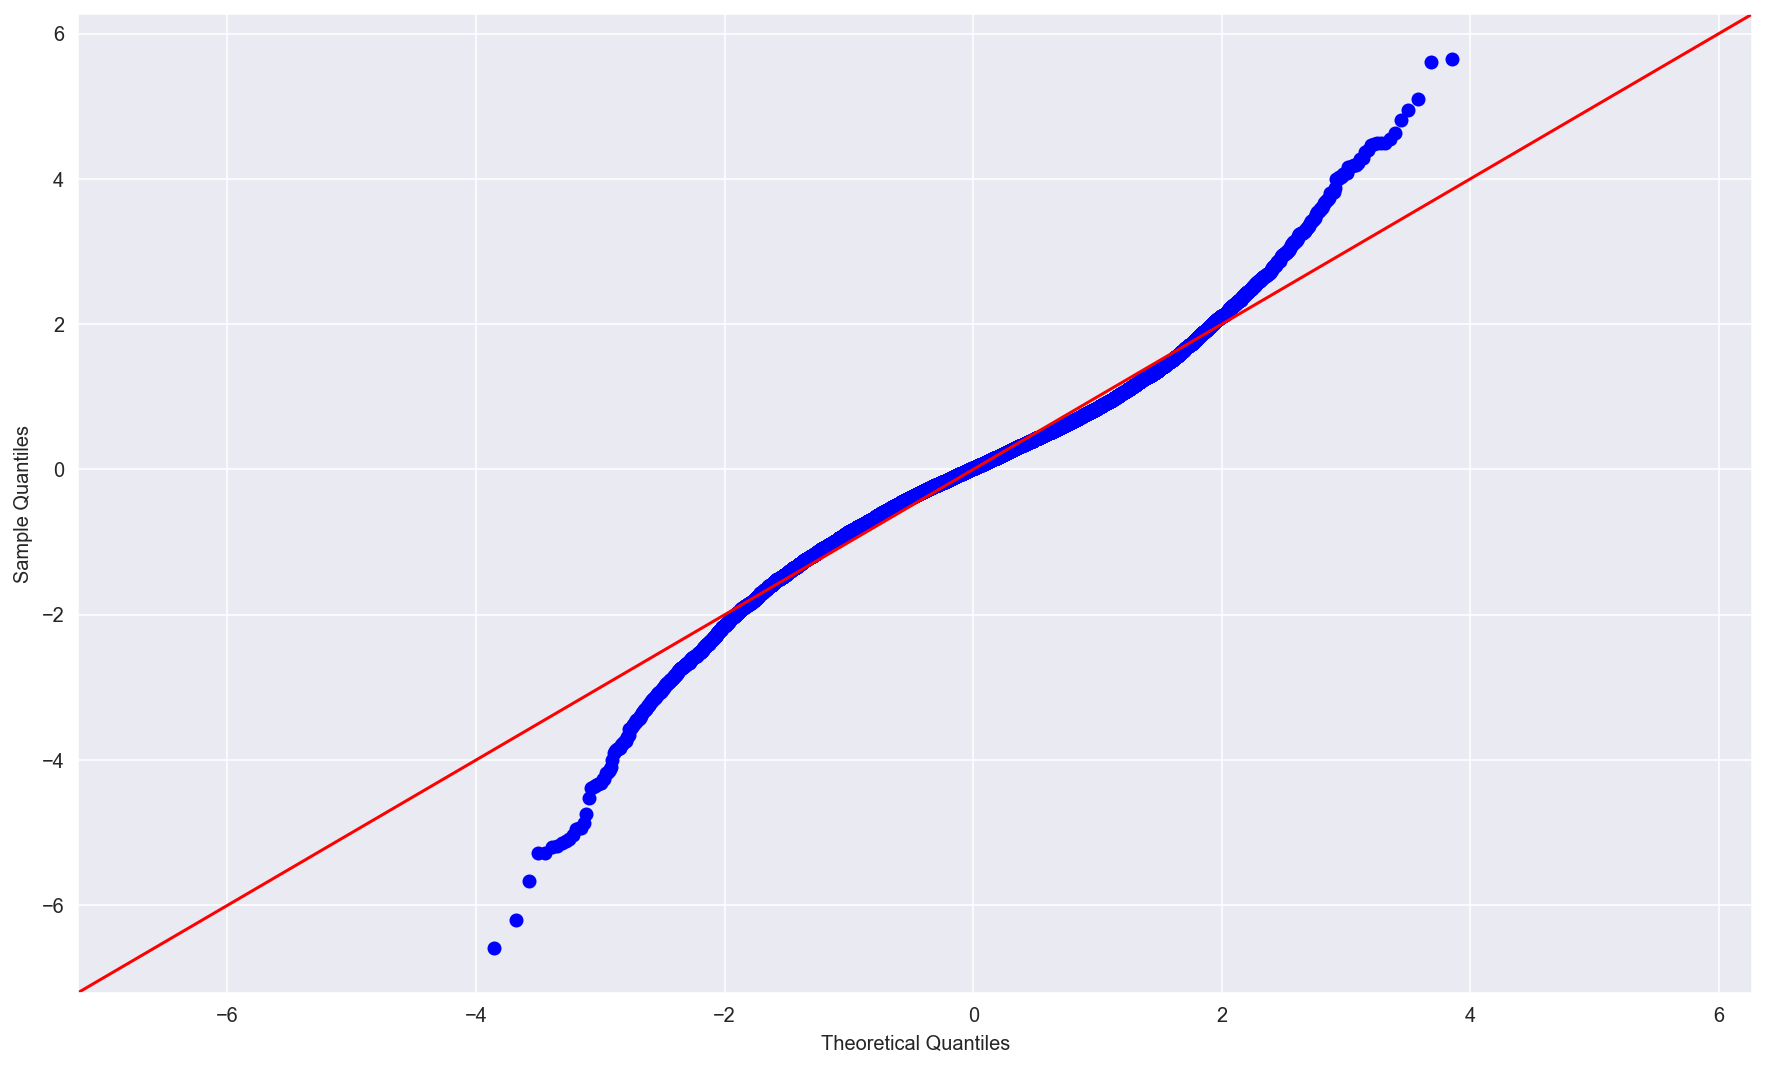

In [69]:
residuals = model2_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [70]:
#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 4056.271922623071),
 ('Prob', 0.0),
 ('Skew', -0.11071828459092932),
 ('Kurtosis', 5.363399055202757)]


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.604179e+03
p-value                        8.247906e-274
f-value                         1.891132e+01
f p-value                      3.984970e-289

 Goldfeld-Quandt test ----
                value
F statistic  0.975443
p-value      0.874746

 Residuals plots ----


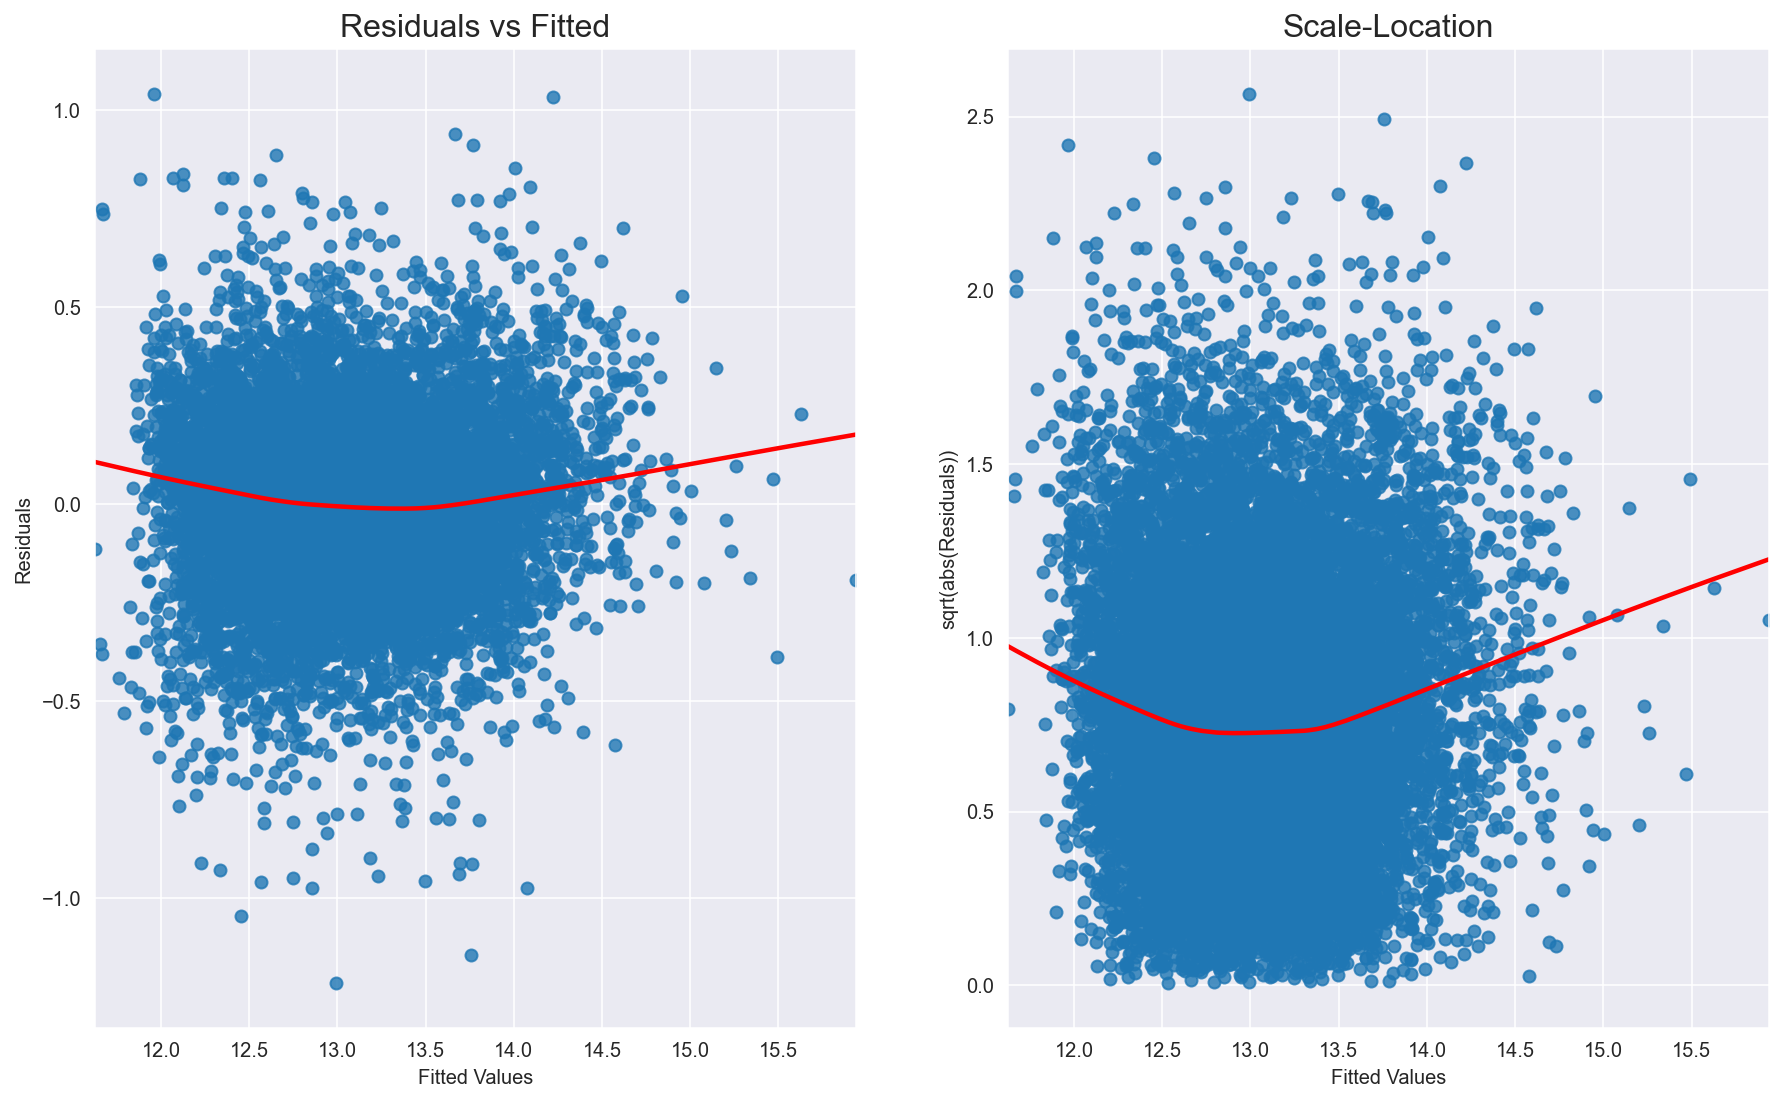

In [71]:
homoscedasticity_test(model2_ols)

## Model 3

Model 3 uses the same dataframe structure as Model 1, but introduces recursive feature elimination (REF) of varying n_parameters  to improve on the model.

### Recursive Feature Elimination (RFE)

In [72]:
#determine how many features we have
len(X_train.columns)

116

In [73]:
#determine n for REF
n = [10, 20, 50, 100]

key_cols = {}

for x in n:
    #instatiate Linear Regression
    lr_rfe = LinearRegression()
    select = RFE(lr_rfe, n_features_to_select=x)
    
    #fit model to RFE
    select.fit(X=X_train, y=y_train)
    
    #obtain the indexes where select.support_ is true
    true_indexes = [i for i, x in enumerate(select.support_) if x]
    
    #create a list of all column names matched with index and add to dictionary
    key_columns = []
    for i in true_indexes:
        key_columns.append(X_train.columns[i])
    key_cols["key_cols_{0}".format(x)] = key_columns 

In [74]:
key_cols

{'key_cols_10': ['sqft_living',
  'lat',
  'sqft_living15',
  'waterfront_1',
  'grade_5',
  'grade_6',
  'grade_7',
  'grade_8',
  'grade_9',
  'zipcode_98004'],
 'key_cols_20': ['sqft_living',
  'lat',
  'sqft_living15',
  'waterfront_1',
  'condition_3',
  'condition_4',
  'condition_5',
  'grade_5',
  'grade_6',
  'grade_7',
  'grade_8',
  'grade_9',
  'zipcode_98004',
  'zipcode_98039',
  'zipcode_98040',
  'zipcode_98103',
  'zipcode_98105',
  'zipcode_98112',
  'zipcode_98116',
  'zipcode_98119'],
 'key_cols_50': ['sqft_living',
  'sqft_lot',
  'sqft_above',
  'lat',
  'sqft_living15',
  'waterfront_1',
  'view_2',
  'view_3',
  'view_4',
  'condition_3',
  'condition_4',
  'condition_5',
  'grade_4',
  'grade_5',
  'grade_6',
  'grade_7',
  'grade_8',
  'grade_9',
  'grade_10',
  'zipcode_98004',
  'zipcode_98005',
  'zipcode_98006',
  'zipcode_98007',
  'zipcode_98008',
  'zipcode_98027',
  'zipcode_98029',
  'zipcode_98033',
  'zipcode_98039',
  'zipcode_98040',
  'zipcode_98

In [75]:
X_train[key_cols['key_cols_10']].shape

(17277, 10)

### Model 3: Testing 10 Features

In [76]:
#create linear regression model for price and setting up cross validation (x3)
model3_10 = LinearRegression()
model3_10.fit(X_train[key_cols['key_cols_10']], y_train);

In [77]:
#setting up cross validation for price in a different way (x3)
model3_10_cval = cross_val(model3_10,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_10_cval_summary = cval_summary(model3_10_cval[0],
                                   model3_10_cval[1],
                                   abs(model3_10_cval[0]-model3_10_cval[1]))

model3_10_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [78]:
#find the test score using the linear model
model3_10_scores = score_model(model3_10,
                           X_train[key_cols['key_cols_10']],
                           X_test[key_cols['key_cols_10']],
                           y_train,
                           y_test)

model3_10_summary = model_summary(model3_10_cval[0],
                              model3_10_cval[1],
                              abs(model3_10_cval[0]-model3_10_cval[1]))
model3_10_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.887. These values resulted in a differential of 0.00035'

### Model 3: n=10, Assumption Tests

In [79]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(train[key_cols['key_cols_10']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_10_ols = ols(formula, train).fit()

<ipython-input-80-77ee9d28042d>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


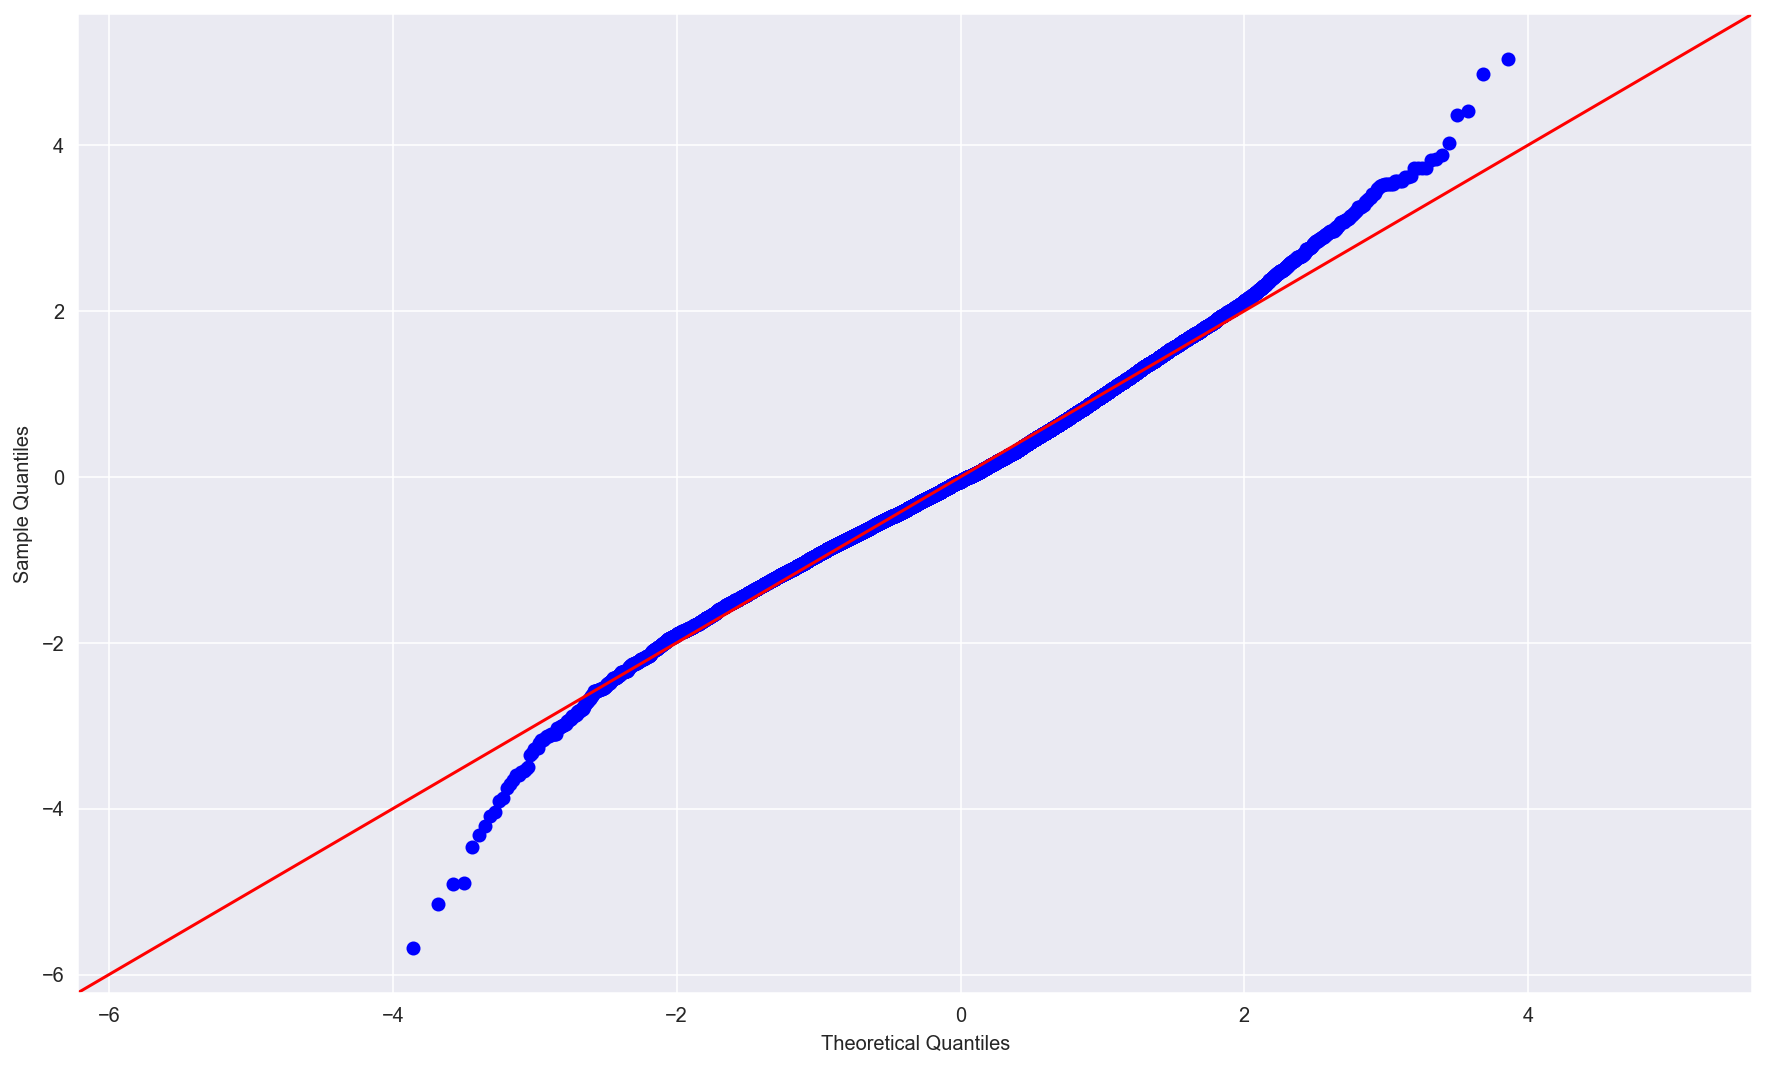

In [80]:
residuals = model3_10_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [81]:
#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 464.2725490030969),
 ('Prob', 1.5293149512412207e-101),
 ('Skew', 0.18863534034057658),
 ('Kurtosis', 3.7089441346810186)]


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   7.538494e+02
p-value                        1.710482e-155
f-value                         7.877410e+01
f p-value                      4.572810e-159

 Goldfeld-Quandt test ----
                value
F statistic  0.974186
p-value      0.887732

 Residuals plots ----


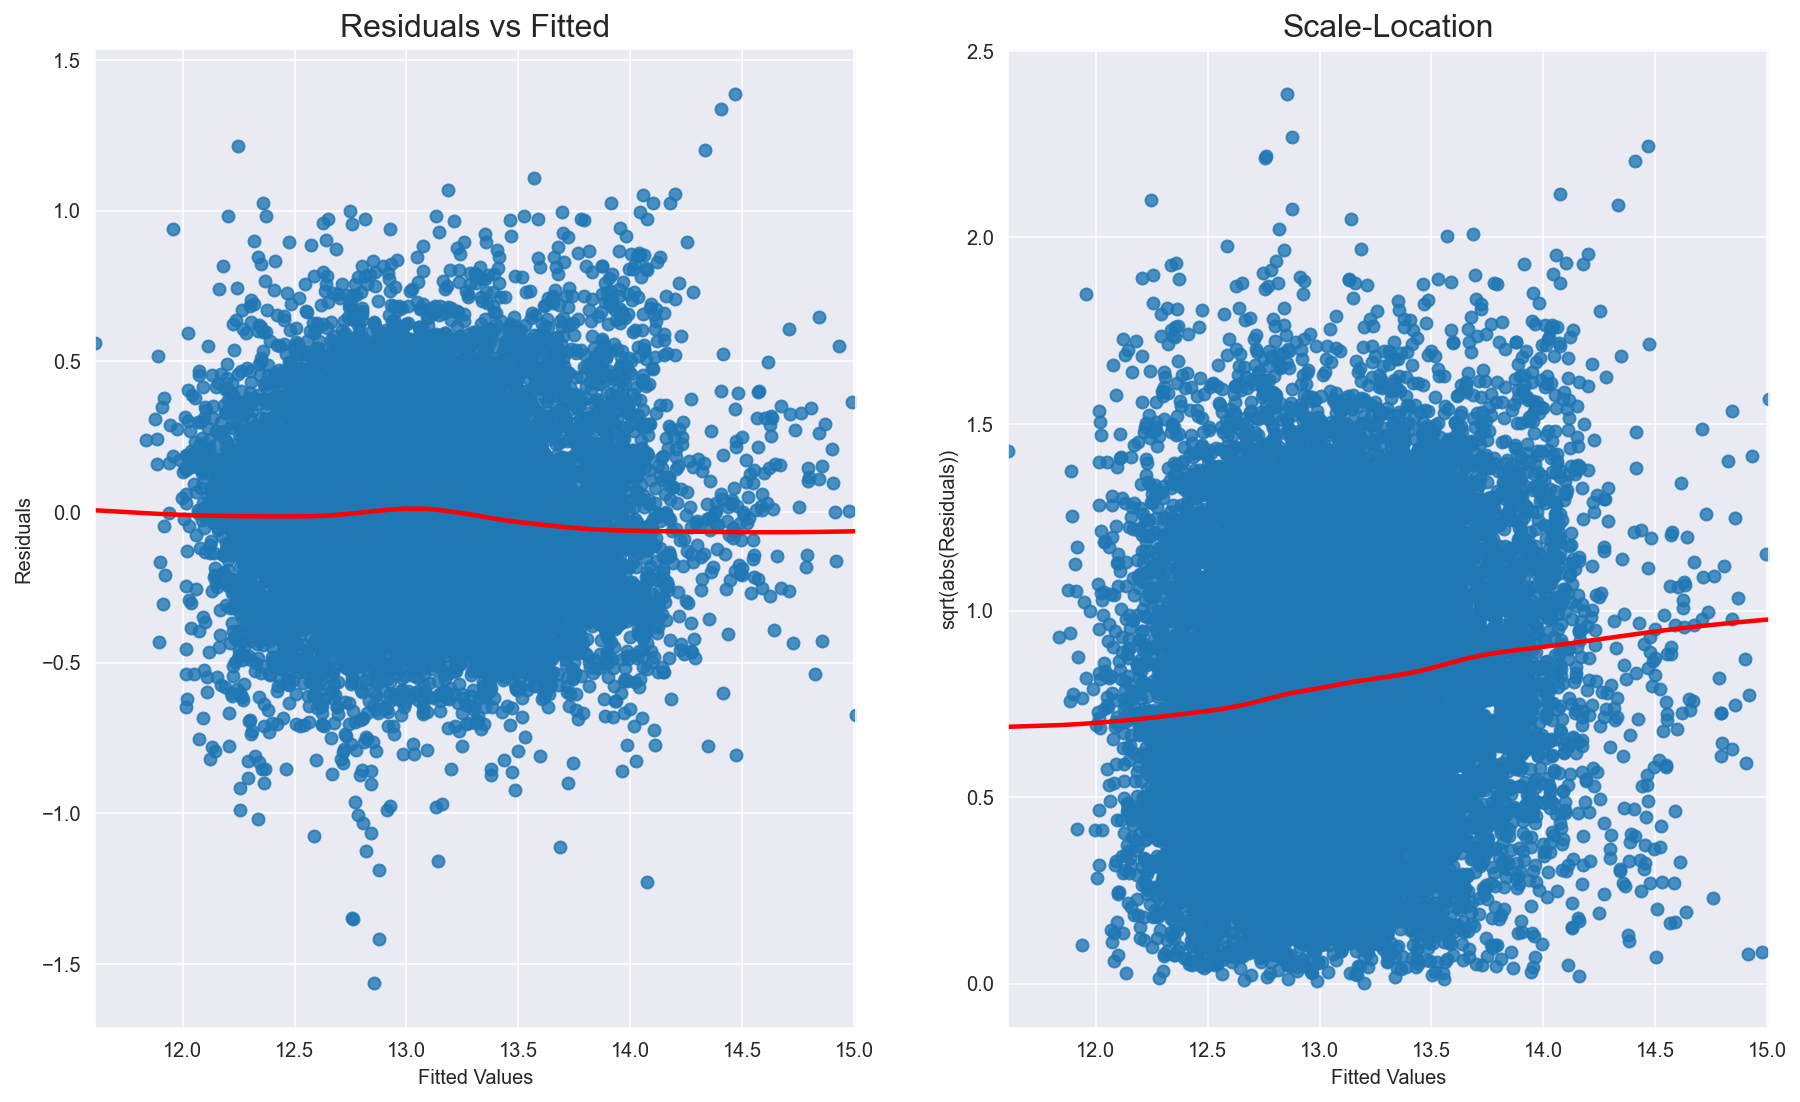

In [82]:
homoscedasticity_test(model3_10_ols)

### Model 3: Testing 20 Features

In [83]:
#create linear regression model for price and setting up cross validation (x3)
model3_20 = LinearRegression()
model3_20.fit(X_train[key_cols['key_cols_20']], y_train);

In [84]:
#setting up cross validation for price in a different way (x3)
model3_20_cval = cross_val(model3_20,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_20_cval_summary = cval_summary(model3_20_cval[0],
                                   model3_20_cval[1],
                                   abs(model3_20_cval[0]-model3_20_cval[1]))

model3_20_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [85]:
#find the test score using the linear model
model3_20_scores = score_model(model3_20,
                           X_train[key_cols['key_cols_20']],
                           X_test[key_cols['key_cols_20']],
                           y_train,
                           y_test)

model3_20_summary = model_summary(model3_20_scores[0],
                              model3_20_scores[1],
                              abs(model3_20_scores[0]-model3_20_scores[1]))
model3_20_summary

'The R-squared value for the train set was 0.781, and the R-sqaured value for the test set was 0.773. These values resulted in a differential of 0.00794'

### Model 3: n=20, Assumption Tests

In [86]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(train[key_cols['key_cols_20']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_20_ols = ols(formula, train).fit()

<ipython-input-87-0c601392181c>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


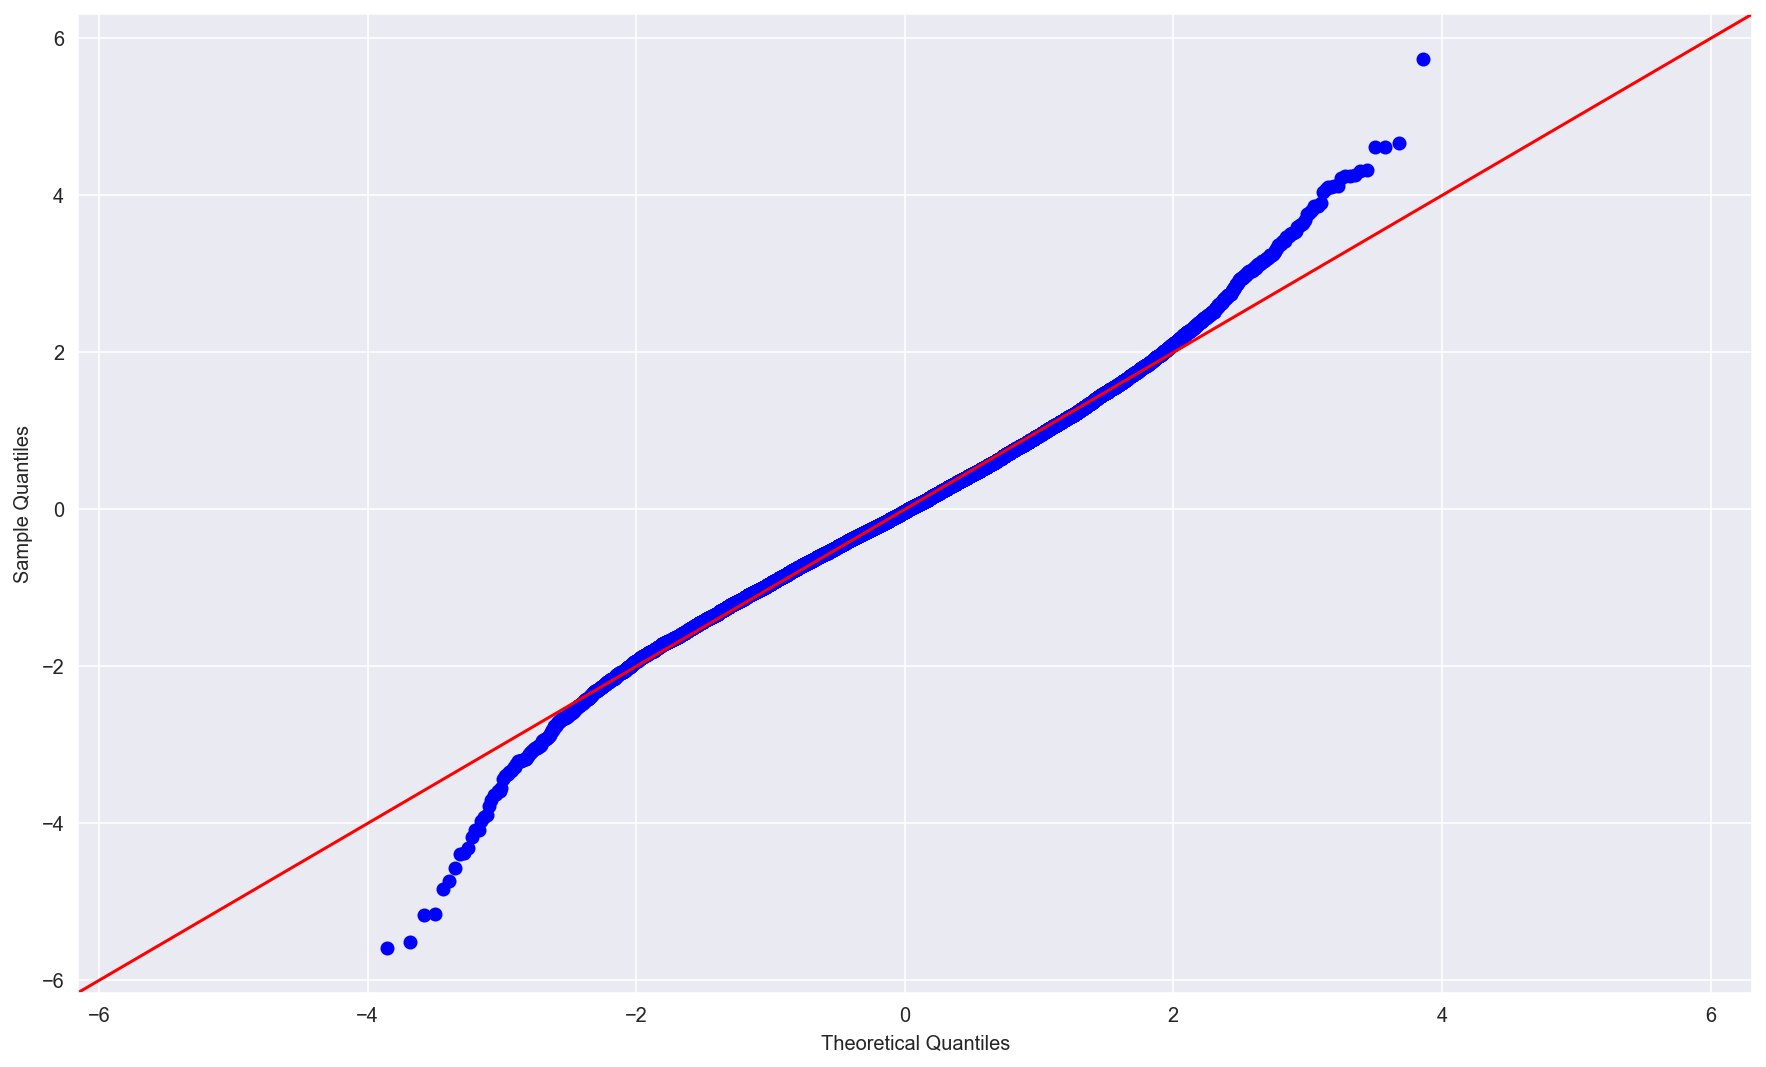

In [87]:
residuals = model3_20_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [88]:
#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 871.1938391802598),
 ('Prob', 6.647548092202302e-190),
 ('Skew', 0.13532498946608879),
 ('Kurtosis', 4.066278639308366)]


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   7.489120e+02
p-value                        9.709850e-146
f-value                         3.909474e+01
f p-value                      3.600840e-149

 Goldfeld-Quandt test ----
                value
F statistic  0.973197
p-value      0.896347

 Residuals plots ----


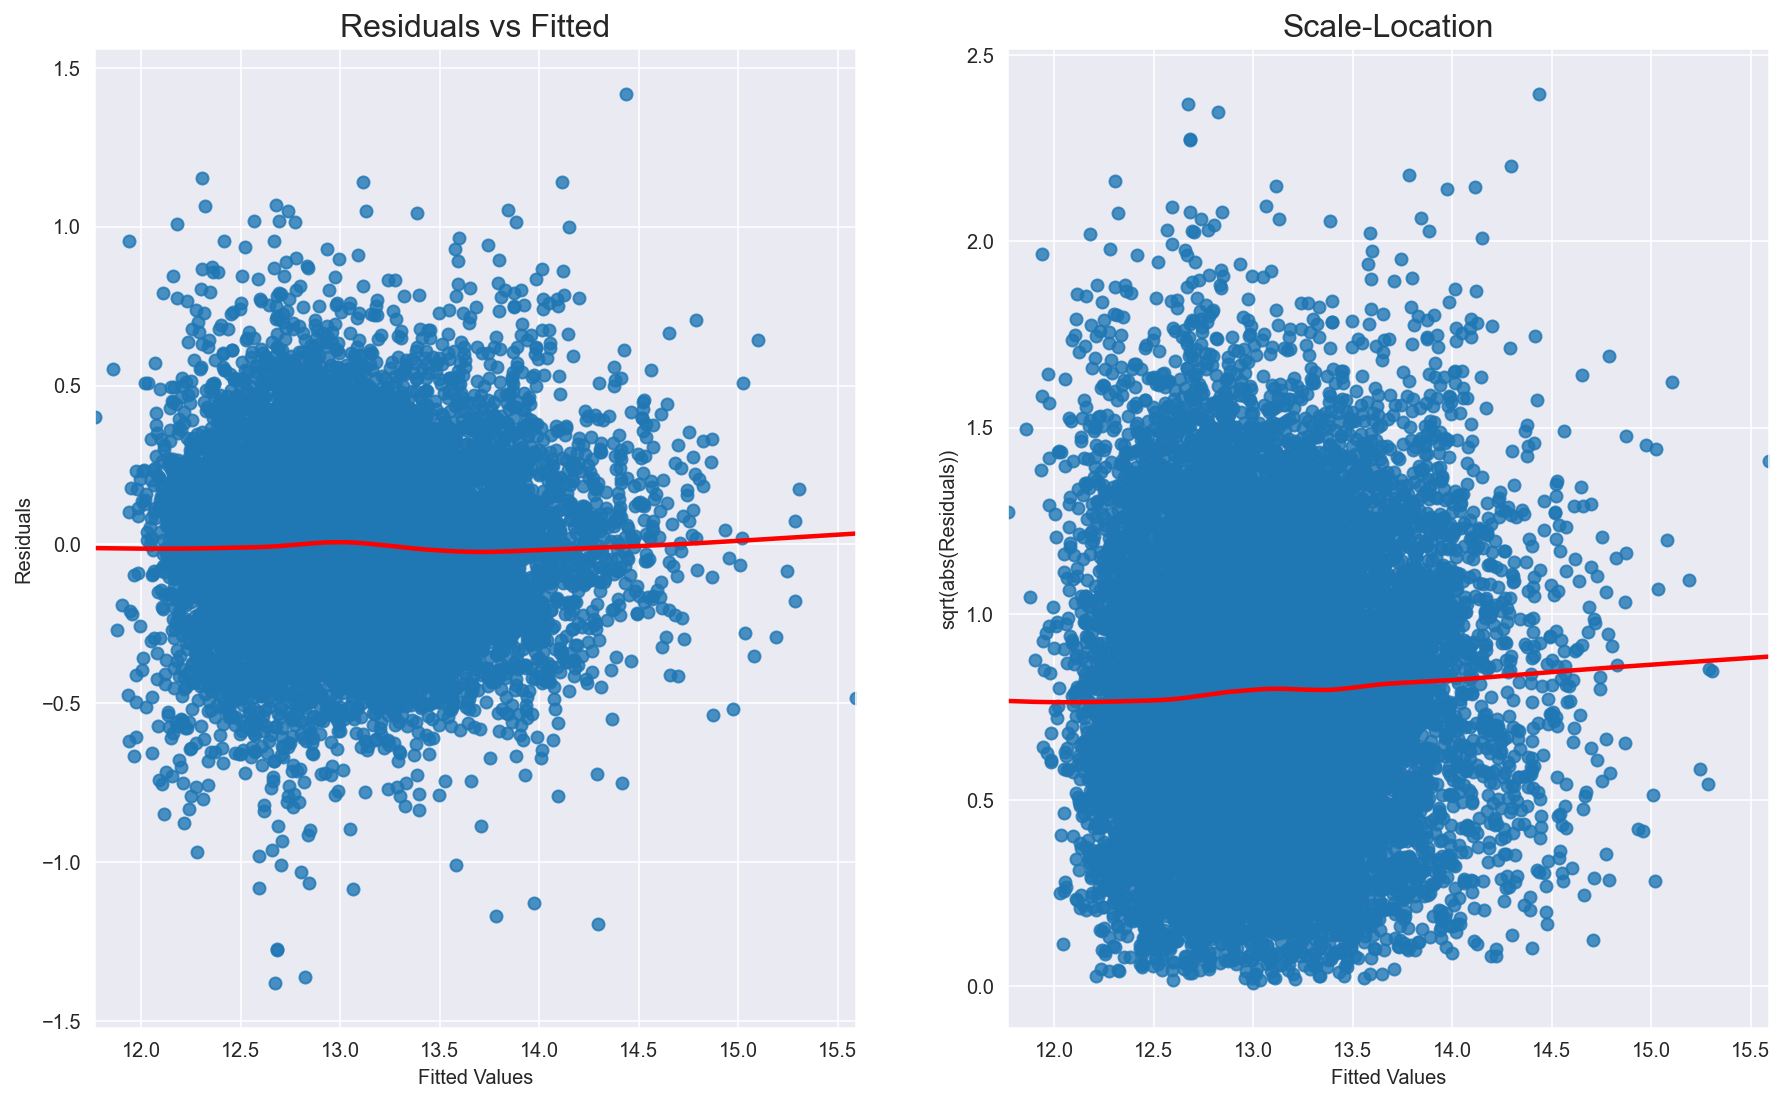

In [89]:
homoscedasticity_test(model3_20_ols)

### Model 3: Testing 50 Features

In [90]:
#create linear regression model for price and setting up cross validation (x3)
model3_50 = LinearRegression()
model3_50.fit(X_train[key_cols['key_cols_50']], y_train);

In [91]:
#setting up cross validation for price in a different way (x3)
model3_50_cval = cross_val(model3_50,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_50_cval_summary = cval_summary(model3_50_cval[0],
                                   model3_50_cval[1],
                                   abs(model3_50_cval[0]-model3_50_cval[1]))

model3_50_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [92]:
#find the test score using the linear model
model3_50_scores = score_model(model3_50,
                           X_train[key_cols['key_cols_50']],
                           X_test[key_cols['key_cols_50']],
                           y_train,
                           y_test)

model3_50_summary = model_summary(model3_50_scores[0],
                              model3_50_scores[1],
                              abs(model3_50_scores[0]-model3_50_scores[1]))
model3_50_summary

'The R-squared value for the train set was 0.869, and the R-sqaured value for the test set was 0.867. These values resulted in a differential of 0.00218'

### Model 3: n=50, Assumption Tests

In [93]:
#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(train[key_cols['key_cols_50']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_50_ols = ols(formula, train).fit()

<ipython-input-94-c7544e0eb547>:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


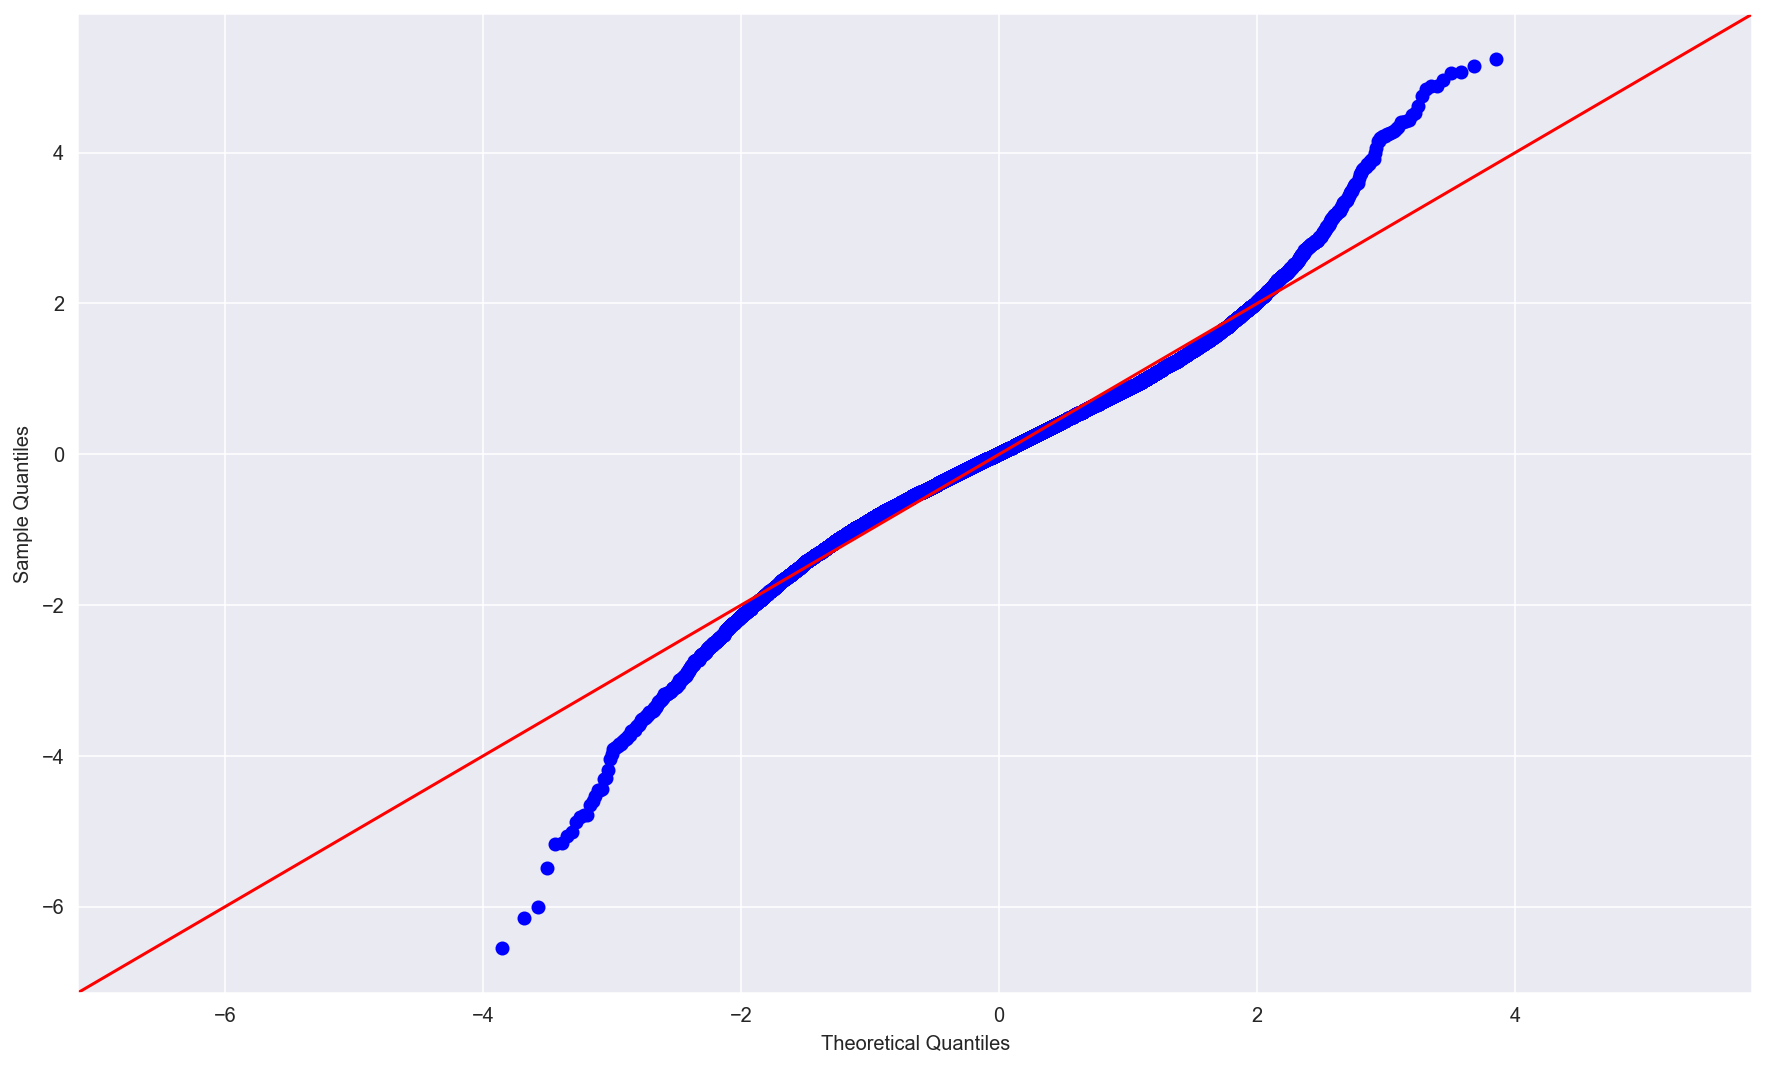

In [94]:
residuals = model3_50_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [95]:
#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))

[('Jarque-Bera', 3559.7834070743766),
 ('Prob', 0.0),
 ('Skew', -0.10183877979249828),
 ('Kurtosis', 5.214388759900137)]


 Breusch-Pagan test ----
                                       value
Lagrange multiplier statistic   1.315014e+03
p-value                        2.001966e-242
f-value                         2.838296e+01
f p-value                      5.118671e-253

 Goldfeld-Quandt test ----
                value
F statistic  0.976794
p-value      0.861675

 Residuals plots ----


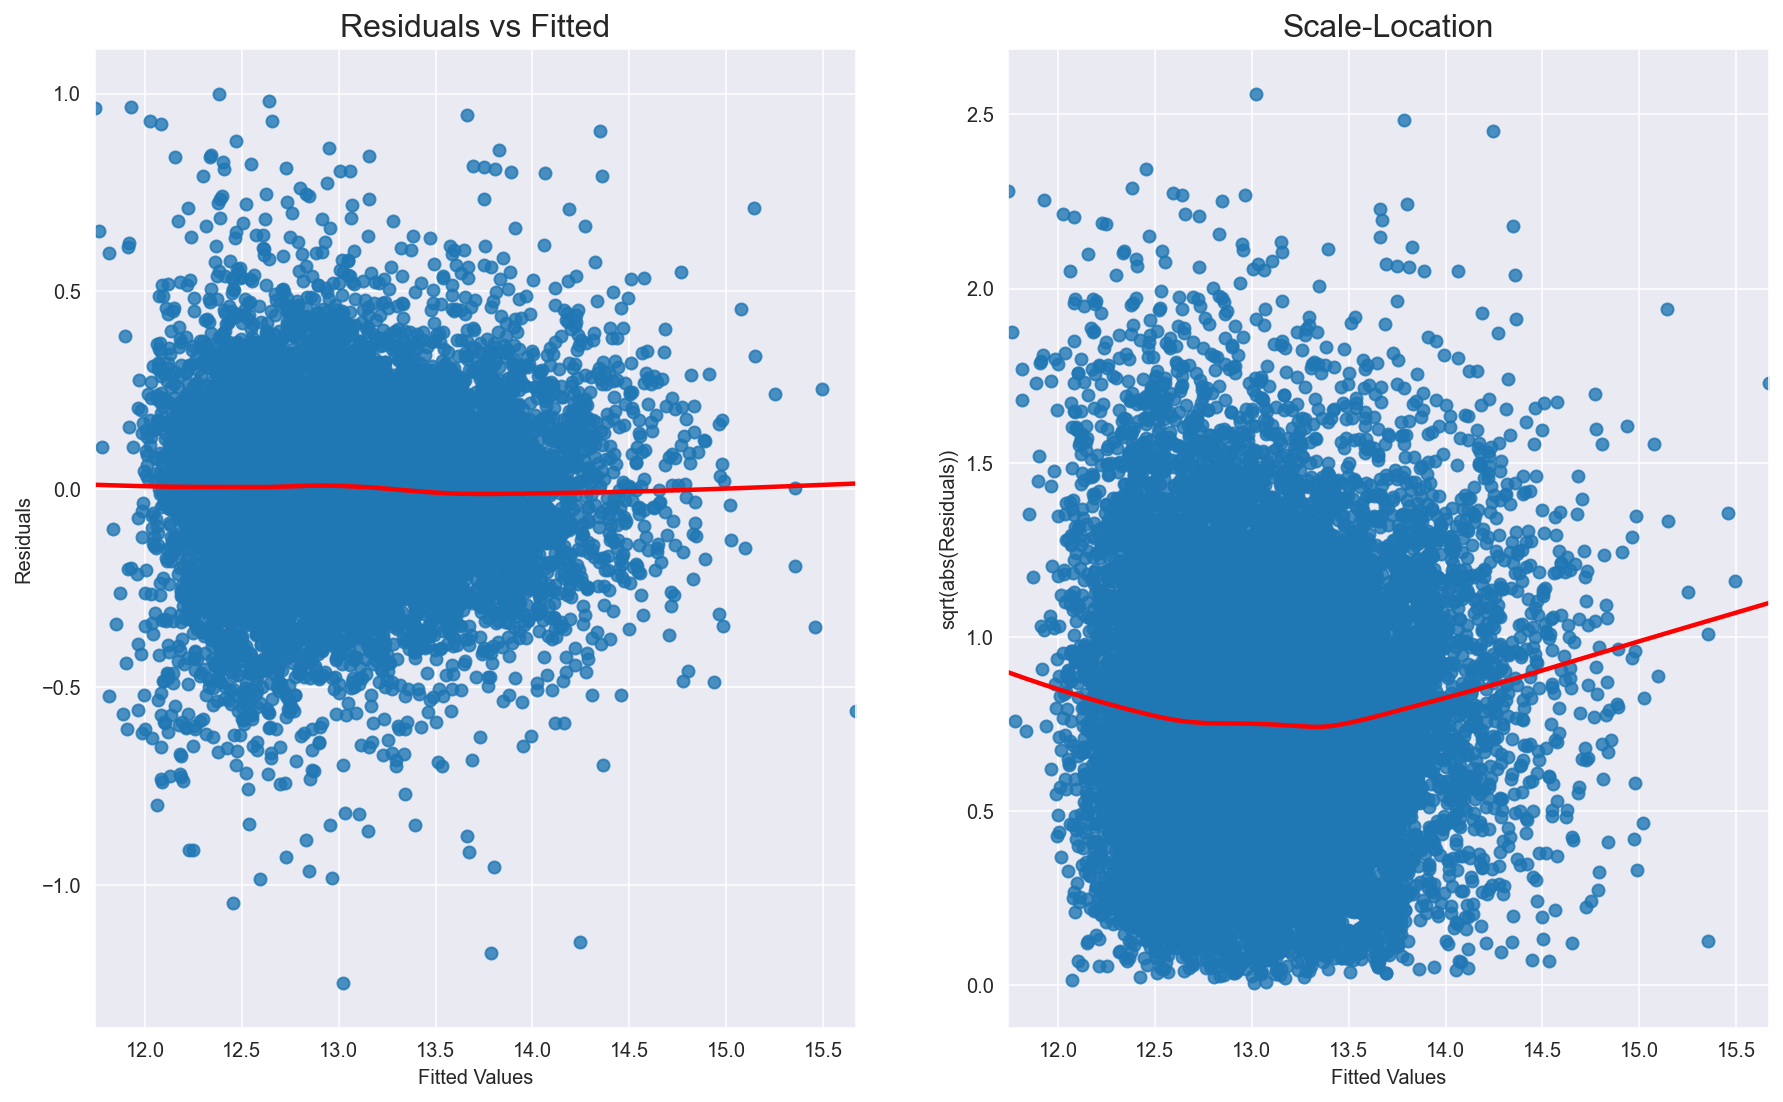

In [96]:
homoscedasticity_test(model3_50_ols)

### Model 3: Testing 100 Features

In [97]:
#create linear regression model for price and setting up cross validation (x3)
model3_100 = LinearRegression()
model3_100.fit(X_train[key_cols['key_cols_100']], y_train);

In [98]:
#setting up cross validation for price in a different way (x3)
model3_100_cval = cross_val(model3_100,
                       X=X,
                       y=ln_y,
                       random_state=0,)

model3_100_cval_summary = cval_summary(model3_100_cval[0],
                                   model3_100_cval[1],
                                   abs(model3_100_cval[0]-model3_100_cval[1]))

model3_100_cval_summary

'The median R-squared values for the train sets were 0.888, the median R-squared values for the test sets were 0.887. These values resulted in a differential of 0.00035'

In [99]:
#find the test score using the linear model
model3_100_scores = score_model(model3_100,
                           X_train[key_cols['key_cols_100']],
                           X_test[key_cols['key_cols_100']],
                           y_train,
                           y_test)

model3_100_summary = model_summary(model3_100_scores[0],
                              model3_100_scores[1],
                              abs(model3_100_scores[0]-model3_100_scores[1]))
model3_100_summary

'The R-squared value for the train set was 0.888, and the R-sqaured value for the test set was 0.885. These values resulted in a differential of 0.00353'

### Model 3: Summary

In [100]:
print(f"10 features {model3_10_scores,(model3_10_scores[0]-model3_10_scores[1])}"),print(f"20 features {model3_20_scores,(model3_20_scores[0]-model3_20_scores[1])}"),print(f"50 features {model3_50_scores,(model3_50_scores[0]-model3_50_scores[1])}"),print(f"100 features {model3_100_scores,(model3_100_scores[0]-model3_100_scores[1])}"),print(f" Previous Best Model{model1_ln_scores,(model1_ln_scores[0]-model1_ln_scores[1])}")

10 features ((0.7277375004997232, 0.7292186976053006), -0.0014811971055773698)
20 features ((0.7806922560877175, 0.7727569589216091), 0.007935297166108413)
50 features ((0.8694806403039756, 0.8672977167306704), 0.0021829235733052954)
100 features ((0.8881262208380661, 0.8845973064822676), 0.003528914355798496)
 Previous Best Model((0.8882149191455071, 0.884596505612474), 0.003618413533033049)


(None, None, None, None, None)

Looking at the score results above it becomes apparent that the trade off for removing features from our original model is a reduced R-squared statistic. It is interesting to note however, that although the 100 feature model's r-squared statistic worsened by a minisule amount, the differental between train and test was also more narrow. This trend continues down to 50 features and then the differential begins to rise again signaling that there may be some "best" number of features for balance between r-squared and the spread between test and train.

# Model 4 Binomial Feature Engineering 

## Binomial Feature Engineering

In [101]:
#setting up binomial features from Train/Test split that uses ln_price as a y value
pf = PolynomialFeatures(degree=2)
pf.fit(X_scaled);

In [102]:
#Training/tranforming the data using the fit pf object. Formatting as DataFrame for ease of use
pdf_train = pd.DataFrame(pf.transform(X_train), columns = pf.get_feature_names())
pdf_test = pd.DataFrame(pf.transform(X_test), columns = pf.get_feature_names())

### Pearson Correlation Coefficient Filtering

In [103]:
#calculating corr to the df with polynomial features to the train y values 
correlations = pdf_train.corrwith(y_train)
correlations_df = pd.DataFrame(correlations)
correlations_df.head()

0
1        NaN
x0  0.012849
x1  0.006988
x2  0.007985
x3  0.005303

In [104]:
#NaN values represent columns containing 0 values, we wont need to consider these
correlations_df.dropna(inplace=True)

In [105]:
#Mapping absolute value over the correlations_df to allow us to find the most impactful coefs
correlations_df[0].map(abs)
#Sorting them so that we can skim the best ones off the top
correlations_df.sort_values(by=0,ascending=False,inplace=True)

In [106]:
#Column names of the top x number of features from our polynomial df, adding 1 to represent the intercept
features = list(correlations_df.index[:250]) + ['1']

### Recursive Feature Elimination

In [107]:
#recrusive selector selects x numver of values from remaining features
select = RFE(lr_rfe, n_features_to_select=250)
select.fit(X = pdf_train[features], y = y_train);

In [108]:
#compiling a list of the selected features
pdf_keepers = [x[0] for x in zip(pdf_train.columns,select.support_) 
               if x[1] == True]

### Model Validation

In [109]:
#instantiating a linear regression object
m4df_model = LinearRegression()

In [110]:
#fitting over traininf pdf and narrowing by selected features
m4df_model.fit(X = pdf_train[pdf_keepers], y = y_train);

In [111]:
r2_train = m4df_model.score(pdf_train[pdf_keepers],y_train)
r2_test = m4df_model.score(pdf_test[pdf_keepers],y_test)
r2_diff = r2_train - r2_test

r2_train, r2_test, r2_diff

(0.8931529168764494, 0.8869523310501543, 0.006200585826295124)

### Model 4: Assumption Tests

In [113]:
#set target
target = 'ln_price'
#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([pdf_train[pdf_keepers], y_train], axis=1)
#join the column names with "+"
columns= "+".join(train.drop(['ln_price'], axis=1).columns)
#set formula
formula = target + '~' +columns
#create the OLS
model4_ols = ols(formula, train).fit()

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
normality(model4_ols)

In [ ]:
homoscedasticity_test(model4_ols)

#set target
target = 'ln_price'

#concate the X and y of the train tests to apply the OLS to the full train data
train = pd.concat([X_train, y_train], axis=1)

#join the column names with "+"
columns= "+".join(train[key_cols['key_cols_50']].columns)

#set formula
formula = target + '~' +columns

#create the OLS
model3_50_ols = ols(formula, train).fit()

residuals = model3_50_ols.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

#linearity test
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(residuals)
list(zip(name, test))